
# 승촌보: 계절별 방류량과 클로로필-a

## 데이터 정보

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

## 주요 내용

- 단지 하룻동안이 아닌 2, 3일 동안의 평균 방류량이 클로로필-a의 농도에 결정적인 영향을 미친다.
- 계절에 따른 적절한 방류량을 데이터 분석을 통해 알아낸다.
- 데이터 분석을 위해 어떠한 종류의 머신러닝 모델 또는 통계 기법을 사용하지 않는다.

## 필수 모듈 임포트

In [1]:
# numpy와 판다스
import numpy as np
import pandas as pd

# 시작화 모듈
import matplotlib.pyplot as plt
import seaborn as sns

# 시간 모듈
from datetime import datetime
import datetime as dt

**데이터프레임 설정**

In [2]:
pd.set_option('display.max_columns', None) # 모든 특성이 잘리지 않도록 함.
# pd.set_option('display.max_rows', None)    # 모든 데이터가 다 보이도록 함.

**훈련 모델 준비**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 모델 저장
import joblib

**그래프 설정**

In [4]:
# seaborn 스타일 지정
sns.set_style("whitegrid")
# sns.set_style("white")

plt.rc('figure', figsize=(10, 6))  # 그래프 기본 크기 지정
plt.rc('font', size=22)            # 폰트 크기
plt.rc('axes', linewidth=2)        # 축 두께
plt.rc('axes', edgecolor='k')      # 축 색상

# show tick marks
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# Set the default font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']

**그래프 한글 설정**

In [5]:
# # 운영체제에 따른 한글 지원을 설정한다. 지원되는 환경은 윈도우, 우분투, 구글 코랩 등이다.

# import platform
# plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
# if platform.system() == 'Windows': # 윈도우
#     from matplotlib import font_manager, rc
#     font_path = "C:/Windows/Fonts/NGULIM.TTF"
#     font = font_manager.FontProperties(fname=font_path).get_name()
#     rc('font', family=font)
# elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
#     # !sudo apt-get install -y fonts-nanum*
#     # !fc-cache -fv
    
#     applyfont = "NanumBarunGothic"
#     import matplotlib.font_manager as fm
#     if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
#         fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
#     plt.rc("font", family=applyfont)
#     plt.rc("axes", unicode_minus=False)

**이미지 저장 함수**

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 승촌보 데이터 불러오기

### 수질 데이터 불러오기

**보 이름**

In [7]:
weir = 'Seungchonbo'

**데이터 저장소**

In [8]:
base_path = "https://github.com/codingalzi/water-data/raw/master/weirs/data/"

**시간 단위로 측정된 승촌보 연도별 수질 데이터 불러오기**

`'측정일/월'` 특성은 date time으로 파싱.

In [9]:
# ! pip install openpyxl

In [10]:
# '측정일/월' 특성은 date time으로 파싱.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

data_file = weir+".xlsx"
scb_yearly = pd.read_excel(base_path+data_file, 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

**2012년도 데이터를 제외한 모든 데이터 통합 함수**

2012년도 데이터는 결측치가 너무 많음.

In [11]:
# 2013년도 데이터부터 합침
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

**연도별 수질 데이터 통합**

In [12]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

In [13]:
scb_yearly_df13

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
3427,2022-05-23 19:00:00,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
3428,2022-05-23 20:00:00,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
3429,2022-05-23 21:00:00,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
3430,2022-05-23 22:00:00,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


**인덱스 지정 및 이름 수정**

인덱스를 `'측정일/월'` 특성으로 변경한다.

In [14]:
scb_yearly_df13 = scb_yearly_df13.set_index('측정일/월')

인덱스의 이름도 변경한다.

In [15]:
scb_yearly_df13.index.name = 'DateTime'

인덱스(`'DateTime'`) 기준으로 정렬한다.

In [16]:
scb_yearly_df13 = scb_yearly_df13.sort_index()

In [17]:
scb_yearly_df13

,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
DateTime,,,,,,,,,
2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
2022-05-23 20:00:00,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
2022-05-23 21:00:00,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3


### 승촌보 유량 데이터 추가

`시간` 특성은 date time으로 파싱해서 불러온다.

**10분 단위로 측정된 승촌보 연도별 유량 데이터 불러오기**

In [18]:
# `시간` 특성은 date time으로 파싱해서 불러온다.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

flow_data_file = weir + "_flow.xlsx"
scb_flow_yearly = pd.read_excel(base_path+flow_data_file, 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

### 연도별 유량 데이터 통합

수질 데이터셋과 맞추기 위해 2012년도 데이터를 제외한 데이터를 통합한다.

In [19]:
# 2013년부터 통합
scb_flow_yearly_df = concat_yearly_df(scb_flow_yearly)

In [20]:
scb_flow_yearly_df

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00:00:00,7.50,3.77,19.82,19.74
1,2013-01-01 00:10:00,7.50,3.77,19.78,19.76
2,2013-01-01 00:20:00,7.50,3.77,19.77,19.82
3,2013-01-01 00:30:00,7.50,3.77,19.77,19.73
4,2013-01-01 00:40:00,7.50,3.77,19.78,19.79
...,...,...,...,...,...
32947,2022-08-17 19:10:00,5.46,1.60,14.01,19.78
32948,2022-08-17 19:20:00,5.47,1.59,18.96,19.78
32949,2022-08-17 19:30:00,5.47,1.58,19.78,19.78
32950,2022-08-17 19:40:00,5.47,1.57,24.72,19.78


인덱스를 시간으로 지정

In [21]:
scb_flow_yearly_df = scb_flow_yearly_df.set_index('시간')

인덱스 이름도 수질 데이터와의 통합을 위해 동일한 이름으로 변경한다.

In [22]:
scb_flow_yearly_df.index.name = 'DateTime'

시간 기준으로 정렬

In [23]:
scb_flow_yearly_df = scb_flow_yearly_df.sort_index()

In [24]:
scb_flow_yearly_df

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
DateTime,,,,
2013-01-01 00:00:00,7.50,3.77,19.82,19.74
2013-01-01 00:10:00,7.50,3.77,19.78,19.76
2013-01-01 00:20:00,7.50,3.77,19.77,19.82
2013-01-01 00:30:00,7.50,3.77,19.77,19.73
2013-01-01 00:40:00,7.50,3.77,19.78,19.79
...,...,...,...,...
2022-08-17 19:10:00,5.46,1.60,14.01,19.78
2022-08-17 19:20:00,5.47,1.59,18.96,19.78
2022-08-17 19:30:00,5.47,1.58,19.78,19.78


**10분 단위를 1시간 단위로 변경**

수질 데이터와의 통합을 위해 시간별 평균값을 활용한다.

In [25]:
scb_flow_yearly_hour_df = scb_flow_yearly_df.resample("H").mean()

In [26]:
scb_flow_yearly_hour_df

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
DateTime,,,,
2013-01-01 00:00:00,7.500000,3.770000,19.773333,19.748333
2013-01-01 01:00:00,7.500000,3.770000,19.701667,19.706667
2013-01-01 02:00:00,7.500000,3.770000,19.748333,19.723333
2013-01-01 03:00:00,7.500000,3.770000,19.613333,19.610000
2013-01-01 04:00:00,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...
2022-08-17 15:00:00,5.536667,1.618333,29.261667,25.190000
2022-08-17 16:00:00,5.525000,1.638333,23.243333,38.923333
2022-08-17 17:00:00,5.483333,1.626667,29.068333,44.878333


### 수질/유량 데이터 합병

수질 데이터와 유량 데이터를 `date/time` 기준으로 합병한다.

In [27]:
# `pd.merge()`에서 `how = 'inner'` 키워드 인자 : 두 데이터에 공통으로 사용된 시간 데이터만 추가(교집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, left_index=True, right_index=True, how='inner')

In [28]:
# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [29]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82257 entries, 2013-01-01 00:00:00 to 2022-05-23 23:00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정소명         82257 non-null  object 
 1   수온 ℃         64574 non-null  float64
 2   수소이온농도       64561 non-null  float64
 3   전기전도도 μS/cm  64524 non-null  float64
 4   용존산소 mg/L    62656 non-null  float64
 5   총유기탄소 mg/L   58675 non-null  float64
 6   총질소 mg/L     59981 non-null  float64
 7   총인 mg/L      58997 non-null  float64
 8   클로로필-a mg/㎥  62876 non-null  float64
 9   상류수위(EL.m)   82231 non-null  float64
 10  하류수위(EL.m)   82231 non-null  float64
 11  유입량(㎥/s)     82231 non-null  float64
 12  방류량(㎥/s)     82231 non-null  float64
dtypes: float64(12), object(1)
memory usage: 8.8+ MB


In [30]:
scb_data.describe()

,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
count,64574.000000,64561.000000,64524.000000,62656.000000,58675.000000,59981.000000,58997.000000,62876.000000,82231.000000,82231.000000,82231.000000,82231.000000
mean,17.309103,7.032307,344.310877,7.500954,4.341878,5.358875,0.118273,50.969729,6.451908,2.465385,32.146464,31.964258
std,8.099525,0.509260,88.450084,3.914830,1.032926,1.963933,0.062979,37.409147,1.528813,1.183083,113.291730,112.716473
min,1.800000,6.100000,92.000000,0.500000,1.600000,0.706000,0.003000,1.000000,2.600000,-0.756667,0.000000,0.000000
25%,9.400000,6.700000,280.000000,4.400000,3.600000,3.820000,0.074000,20.975000,5.570000,1.538333,11.320000,11.133333
50%,17.300000,6.900000,344.000000,7.600000,4.200000,5.097000,0.106000,43.200000,7.290000,2.546667,16.280000,15.108333
75%,24.700000,7.100000,415.000000,10.400000,5.000000,6.660000,0.148000,74.100000,7.520000,3.550000,25.570000,26.649167
max,36.100000,10.000000,730.000000,24.300000,19.300000,12.357000,0.745000,453.500000,157.920000,12.486667,4581.450000,4088.446667


### 이상치 제거

상류수위가 10 (EL.m) 이상인 데이터가 존재한다.
그런데 승촌보 수위는 그 이상이 될 수 없기에 이상치로 간주하고 삭제한다.

In [31]:
scb_data = scb_data[scb_data['상류수위(EL.m)'] <= 10]
scb_data.describe()

,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
count,64548.000000,64535.000000,64498.000000,62630.000000,58651.000000,59955.000000,58971.000000,62850.000000,82203.000000,82203.000000,82203.000000,82203.000000
mean,17.308639,7.032307,344.316087,7.501071,4.341445,5.359145,0.118258,50.971271,6.444988,2.463510,31.215314,31.095678
std,8.099587,0.509353,88.451036,3.914639,1.032804,1.963861,0.062981,37.413957,1.351669,1.175611,96.401627,96.811397
min,1.800000,6.100000,92.000000,0.500000,1.600000,0.706000,0.003000,1.000000,2.600000,-0.756667,0.000000,0.000000
25%,9.400000,6.700000,281.000000,4.400000,3.600000,3.821000,0.074000,20.900000,5.570000,1.538333,11.320000,11.133333
50%,17.300000,6.900000,344.000000,7.600000,4.200000,5.097000,0.106000,43.200000,7.290000,2.546667,16.280000,15.105000
75%,24.700000,7.100000,415.000000,10.400000,5.000000,6.659000,0.148000,74.100000,7.520000,3.550000,25.560000,26.636667
max,36.100000,10.000000,730.000000,24.300000,19.300000,12.357000,0.745000,453.500000,9.993333,9.925000,3630.926667,3430.493333


## 데이터셋 전처리

**특성 선택**

데이터 분석에 사용하지 않을 특성들은 삭제한다.

In [32]:
to_be_removed = ['측정소명', '수소이온농도']

scb_data = scb_data.drop(to_be_removed, axis=1)

**특성 영문명 지정**

모델 훈련에 사용되는 모든 특성명을 영문으로 변경한다.
현재 남아 있는 특성들은 다음과 같다.

In [33]:
scb_data.columns

Index(['수온 ℃', '전기전도도 μS/cm', '용존산소 mg/L', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '하류수위(EL.m)', '유입량(㎥/s)', '방류량(㎥/s)'],
      dtype='object')

각 특성의 영문명은 다음과 같다.

In [34]:
features_english = {
    '수온 ℃' : 'Temp',
    '전기전도도 μS/cm' : 'EC',
    '용존산소 mg/L' : 'DO',
    '총유기탄소 mg/L' : 'TOC',
    '총질소 mg/L' : 'TN',
    '총인 mg/L' : 'TP',
    '클로로필-a mg/㎥' : 'Chl-a',
    '상류수위(EL.m)' : 'Upstream',
    '하류수위(EL.m)' : 'Downstream',
    '유입량(㎥/s)' : 'Inflow',
    '방류량(㎥/s)' : 'D-Flow'
}

영문명으로 변경(renaming)한다.

In [35]:
scb_data = scb_data.rename(columns=features_english)
scb_data

,Temp,EC,DO,TOC,TN,TP,Chl-a,Upstream,Downstream,Inflow,D-Flow
DateTime,,,,,,,,,,,
2013-01-01 00:00:00,3.9,374.0,11.4,2.5,NaN,NaN,7.2,7.50,3.770000,19.773333,19.748333
2013-01-01 01:00:00,3.9,375.0,11.4,2.5,NaN,NaN,6.9,7.50,3.770000,19.701667,19.706667
2013-01-01 02:00:00,4.0,374.0,11.4,2.5,NaN,NaN,6.8,7.50,3.770000,19.748333,19.723333
2013-01-01 03:00:00,4.1,375.0,11.4,2.5,NaN,NaN,6.9,7.50,3.770000,19.613333,19.610000
2013-01-01 04:00:00,4.0,380.0,11.3,2.6,NaN,NaN,6.9,7.50,3.770000,19.661667,19.665000
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,26.6,419.0,NaN,6.7,5.825,0.108,66.2,5.44,1.530000,12.763333,12.766667
2022-05-23 20:00:00,26.3,425.0,NaN,6.5,5.803,0.107,61.2,5.44,1.533333,12.788333,12.786667
2022-05-23 21:00:00,25.9,417.0,NaN,6.7,5.909,0.107,58.3,5.44,1.531667,12.753333,12.743333


### 1시간 단위로 정리된 데이터를 1일 단위로 변경

클로로필-a 수치가 일정 기간 유지될 때 각 특성의 일별 변화를 추적하려 한다.
이를 위해 모든 특성의 일별 평균값을 이용한다.

In [36]:
scb_df_daily = scb_data.resample("D").mean()
scb_df_daily

,Temp,EC,DO,TOC,TN,TP,Chl-a,Upstream,Downstream,Inflow,D-Flow
DateTime,,,,,,,,,,,
2013-01-01,4.113043,406.391304,10.795652,2.791667,NaN,NaN,7.025000,7.490903,3.761667,19.044861,18.733472
2013-01-02,4.282609,431.260870,9.156522,2.839130,NaN,NaN,7.056522,7.501458,3.751597,18.648889,18.929167
2013-01-03,3.830435,416.565217,7.639130,3.058333,NaN,NaN,7.195833,7.499236,3.737708,16.611111,16.621250
2013-01-04,3.313043,402.000000,8.830435,2.730435,NaN,NaN,7.126087,7.489722,3.726389,15.713681,15.805556
2013-01-05,3.165217,409.304348,8.839130,2.800000,NaN,NaN,7.220833,7.494722,3.719722,13.181319,13.062361
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,21.933333,477.380952,NaN,6.066667,7.954952,0.096714,48.766667,5.422292,1.507292,7.193333,6.935208
2022-05-20,22.391304,469.434783,1.185714,6.323810,7.994000,0.094545,54.026087,5.483750,1.498681,9.980069,8.437014
2022-05-21,23.054167,460.041667,0.812500,6.162500,7.449708,0.107333,56.941667,5.530972,1.560486,11.699722,12.939444


일부 특성에 결측치가 많지만 지금 당장 제거하지는 않는다.
이유는 이어서 다루는 클로로필-a와 녹조경보와의 연관성에서 일부 결측치가 자연스럽게 제거될 것이기 때문이다.

In [37]:
scb_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3430 entries, 2013-01-01 to 2022-05-23
Freq: D
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Temp        2849 non-null   float64
 1   EC          2849 non-null   float64
 2   DO          2826 non-null   float64
 3   TOC         2682 non-null   float64
 4   TN          2698 non-null   float64
 5   TP          2691 non-null   float64
 6   Chl-a       2772 non-null   float64
 7   Upstream    3430 non-null   float64
 8   Downstream  3430 non-null   float64
 9   Inflow      3430 non-null   float64
 10  D-Flow      3430 non-null   float64
dtypes: float64(11)
memory usage: 321.6 KB


## 호소수 클로로필-a 수질환경기준에 따른 방류량과 수온의 변화

2018년 5월에 개정된 호소수의 클로로필-a ($\mathrm{mg}$/$\mathrm{m}^3$)에 수질환경기준은 다음과 같다.

| 등급 | 기준 |
| :---: | :---: |
| 매우 좋음 | 5 이하 |
| 좋음      | 9 이하 |
| 약간 좋음 | 14 이하 |
| 보통      | 20 이하 |
| 약간 나쁨 | 35 이하 |
| 나쁨      | 70 이하 |
| 매우 나쁨 | 70 초과 |

또한 아래 표에서처럼 2015년까지는 
클로로필-a ($\mathrm{mg}$/$\mathrm{m}^3$) 농도가 지정된 기준값 이상으로 2주동안 지속되는 경우 
녹조발생 주의보/경보/대발생을 발령했다.
(참고: 조류경보제 개선으로 체계적인 녹조관리(2015.12.1 보도자료))

| 구분 | 기준 |
| :---: | :---: |
| 주의보(관심) | 15 이상 |
| 경보(경계) | 25 이상 |
| 대발생 | 100 이상 |

이에 착안하여 클로로필-a 농도가 특정값 이상으로 2주 동안 지속될 때의 수온과 방류량를 변화를 확인해 본다.
이를 통해 클로로필-a 농도 예측에 방류량과 수온이 매우 중요한 요인임을 확인할 수 있다.
무엇보다도 어떠한 머신러닝 모델 학습 등을 적용하지 않고
주어진 데이터의 통계 자료만을 이용하여 결과를 유도한다.

**`feature_fordays()` 함수**

`feature` 값이 `feature_interval` 구간 사이에 머무른 날이 `days` 일 이상 지속된 날짜 데이터만 추출한다. 
`days`의 기본값은 14일로 지정한다.

In [38]:
def feature_fordays(df=scb_df_daily, feature='Chl-a', feature_interval=[100, np.inf], days=14):
    
    # feature 값이 연속적으로 지정된 구간에 머문 날짜 대상 마스크
    mask = (df[feature].rolling(window=days).min() > feature_interval[0]) & (df[feature].rolling(window=days).max() <= feature_interval[1])
    
    df_days = df[mask]

    return df_days

**Features with units**

In [39]:
feature_units_ = ['Temp ($^\circ\!$C)',
                    'Electrical Conductivity',
                    'Dissolved Oxygen',
                    'Total Organic Carbon',
                    'Total Nitrogen',
                    'Total Phosphorus',
                    'Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)',
                    'Upstream',
                    'Downstream',
                    'Inflow',
                    'D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)']

feature_units = dict(zip(features_english.values(), feature_units_))

In [40]:
feature_units

{'Temp': 'Temp ($^\\circ\\!$C)',
 'EC': 'Electrical Conductivity',
 'DO': 'Dissolved Oxygen',
 'TOC': 'Total Organic Carbon',
 'TN': 'Total Nitrogen',
 'TP': 'Total Phosphorus',
 'Chl-a': 'Chl-a ($\\mathdefault{mg}/\\mathdefault{m}^3$)',
 'Upstream': 'Upstream',
 'Downstream': 'Downstream',
 'Inflow': 'Inflow',
 'D-Flow': 'D-Flow ($\\mathdefault{m}^3/\\mathdefault{s}$)'}

**`plot_feature_fordays()` 함수**

`feature` 값이 `feature_interval` 구간에서 `days`일 동안 지속되는 경우의
`feature_out` 특성의 구간별 빈도를 히스토그램으로 나타낸다.

In [41]:
def plot_feature_fordays(df=scb_df_daily, feature='Chl-a', feature_interval=[100, np.inf], days=14, 
                         feature_out='D-Flow', bins=range(0, 61, 2), xticks=range(0, 61, 10)):

    df = feature_fordays(df, feature, feature_interval, days)

    fig, ax = plt.subplots()

    ax.hist(df[feature_out], bins=bins)

    ax.set_xticks(xticks)
    ax.set_xlabel(f'{feature_units[feature_out]} ')
    ax.set_ylabel('Frequency')
    
    plt.show()

In [42]:
plt.rc('font', size=22)            # 폰트 크기

**방류량 히스토그램**

클로로필-a의 농도가 2주 이상 일정 기준 이상 유지될 때 방류량 빈도를 히스토그램으로 나타낸다.

- 클로로필-a 농도가 20 이하인 경우의 방류량 히스토그램

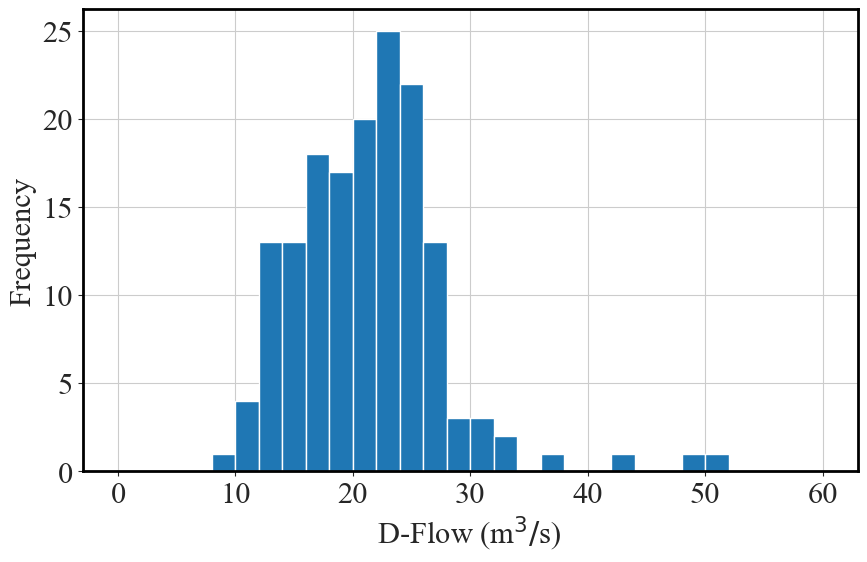

In [43]:
plot_feature_fordays(feature_interval=[0, 20])

- 클로로필-a 농도가 20 초과, 70 이하인 경우의 방류량 히스토그램

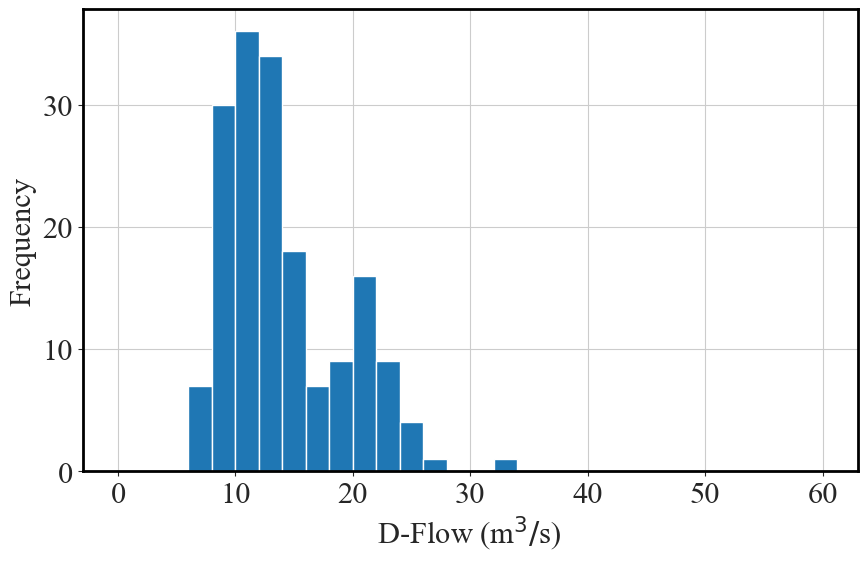

In [44]:
plot_feature_fordays(feature_interval=[20, 70])

- 클로로필-a 농도가 70 초과인 경우의 방류량 히스토그램

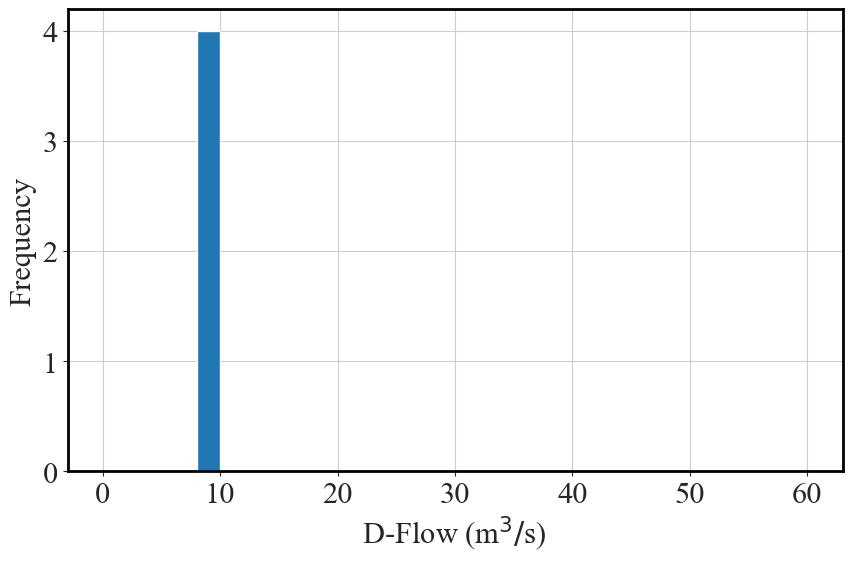

In [45]:
plot_feature_fordays(feature_interval=[68, 100])

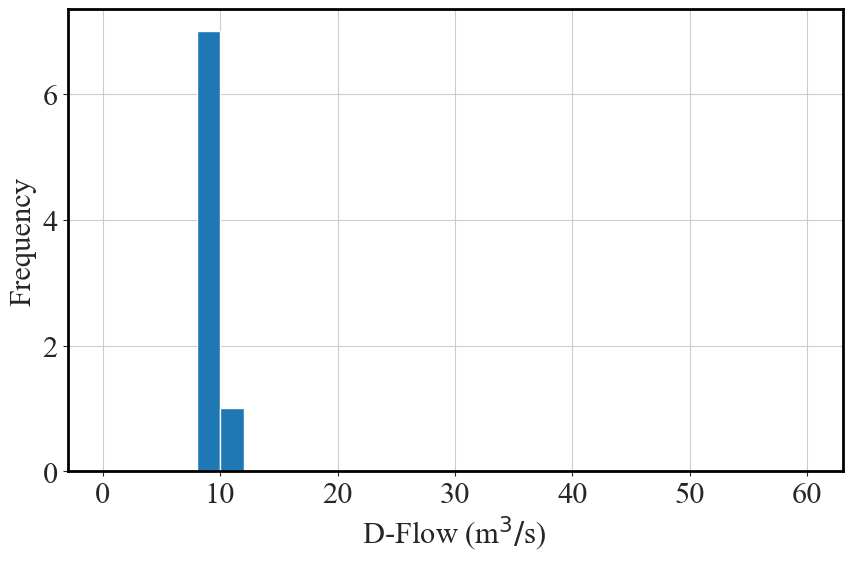

In [46]:
plot_feature_fordays(feature_interval=[65, 100])

- 클로로필-a 농도가 100 초과인 경우의 방류량 히스토그램

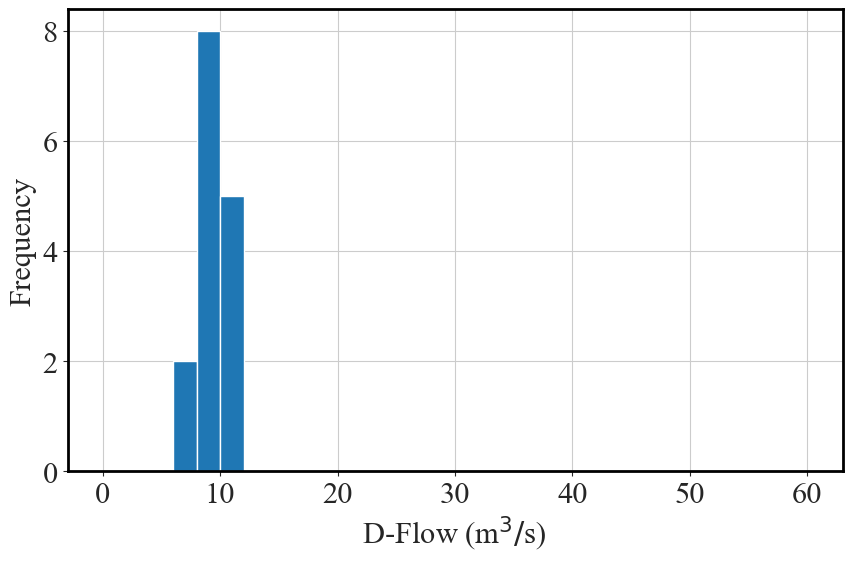

In [47]:
plot_feature_fordays(feature_interval=[100, np.inf])

**수온 히스토그램**

클로로필-a의 농도가 50 또는 100 이상 2주 이상 지속되면 방류량이 10 전후인 경우가 매우 많아진다.
방류량이 그렇게 오랜 시간동안 적은 이유는 한국 기후의 특성상 강우량이 적은 시기,
특히 겨울일 가능성이 높다.
실제로 수온에 대한 히스토그램을 그려보면, 낮은 수온에서도 클로로필-a 수치가 50이상 높은 농도의 수치가 2주동안 지속되는 경우가 많음을 확인할 수 있다.

- 클로로필-a 농도가 50 이상인 경우의 수온 히스토그램: 
    수온의 분포를 보면 클로로필-a의 농도가 2주이상 유지되는 경우가 계절에 상관없이 발생함을 알 수 있다.
    그래도 10도 이하의 경우가 가장 많은데, 이는 특히 겨울에 클로로필-a의 농도가 높게 유지된다는 것을 보여준다.
    앞서 방류량 히스토그램에서 확인했듯이 우리나라 겨울철에 강우량 등 승촌보에 유입되는 수량이 기본적으로 적기 때문에
    수온과 상관없이 클로로필-a의 수치가 높게 유지되는 것으로 보인다.

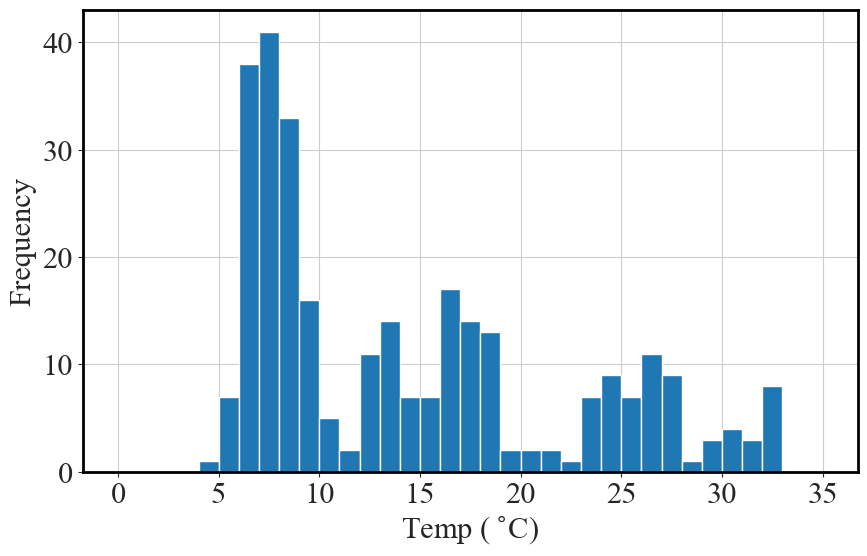

In [48]:
plot_feature_fordays(feature_interval=[50, np.inf], feature_out='Temp', bins=range(0, 36, 1), xticks=range(0, 36, 5))

- 클로로필-a 농도가 70 이상인 경우의 수온 히스토그램: 
    수온이 10도 이하의 경우의 비중이 더 높아진다. 즉, 수온이 낮은 경우에 오히려 매우 나쁨 수준의 클로로필-a의 농도가 겨울에 상대적으로 보다 자주
    발생한다는 것을 보여준다.

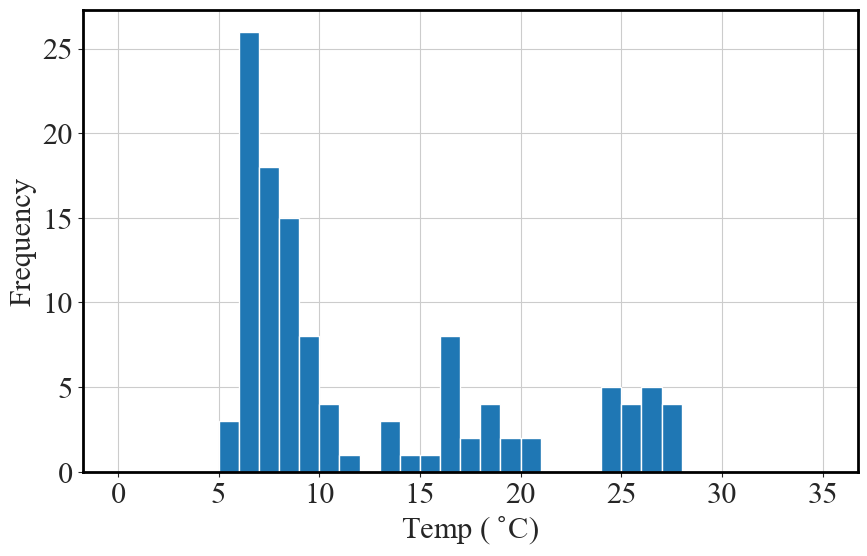

In [49]:
plot_feature_fordays(feature_interval=[70, np.inf], feature_out='Temp', bins=range(0, 36, 1), xticks=range(0, 36, 5))

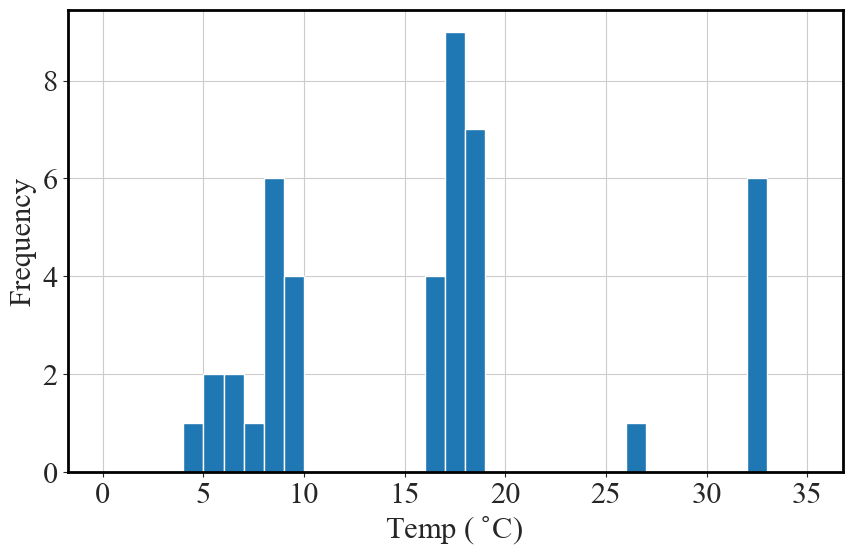

In [50]:
plot_feature_fordays(feature_interval=[50, 100], feature_out='Temp', bins=range(0, 36, 1), xticks=range(0, 36, 5))

- 클로로필-a 농도가 100 이상인 경우의 수온 히스토그램: 
    이번엔 수온의 분포가 더욱 극단적이다. 수온이 한 번을 제외하고는 4도에서 12도 사이에만 몰려있다.
    즉, 클로로필-a의 농도가 100이상 2주동안 유지된 경우가 20여회로 많지는 않았지만 대부분 겨울에, 
    그것도 극단적으로 수량이 적었던 기간동안 발생했다는 의미다.
    나머지 한 번은 여름에 한 번 발생했는데 수온이 2주 이상 30도 정도로 유지된 경우다.

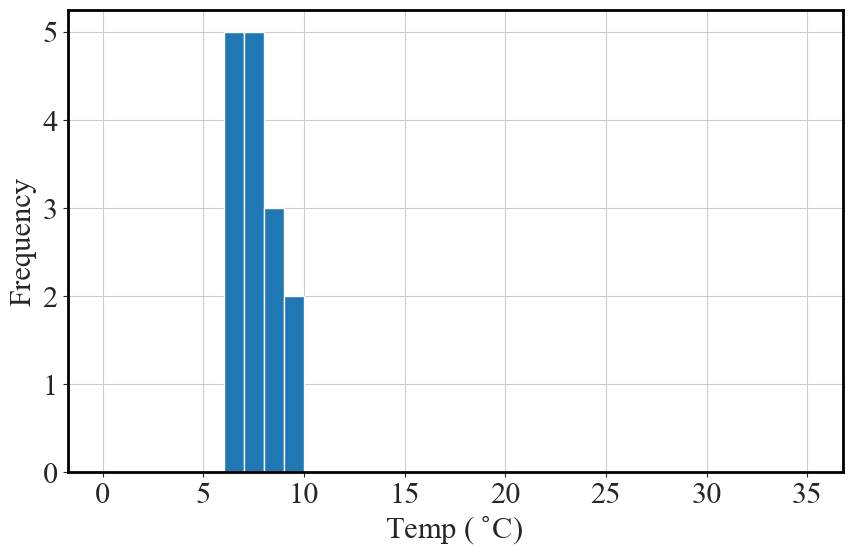

In [51]:
plot_feature_fordays(feature_interval=[100, np.inf], feature_out='Temp', bins=range(0, 36, 1), xticks=range(0, 36, 5))

실제로 클로로필-a의 수치가 100을 초과하여 2주동안 지속되는 시기를 확인하면 다음과 같이 2022년 2월 16일부터 3월 2일까지이다.

In [52]:
scb_df_daily_100 = feature_fordays(feature_interval=[100, np.inf], days=14)

scb_df_daily_100

,Temp,EC,DO,TOC,TN,TP,Chl-a,Upstream,Downstream,Inflow,D-Flow
DateTime,,,,,,,,,,,
2022-02-16,8.083333,452.375000,9.883333,4.991667,10.063625,0.112500,131.812500,5.959931,1.520208,9.143889,8.890486
2022-02-17,7.325000,455.583333,10.725000,5.137500,10.086625,0.117875,141.195833,5.964792,1.509931,9.190903,8.849236
2022-02-18,7.304348,454.608696,12.030435,5.315000,10.179952,0.109000,142.256522,5.966250,1.512847,10.193819,11.048403
2022-02-19,7.062500,455.583333,11.608333,5.166667,10.702762,0.103542,127.221739,5.956042,1.509236,9.133333,8.107431
2022-02-20,6.458333,462.125000,10.091667,5.075000,10.674091,0.105458,107.775000,5.977847,1.517222,10.311736,10.995069
2022-02-21,6.745455,461.636364,10.386364,5.090000,10.234417,0.106000,102.059091,5.959514,1.519097,9.600486,8.917014
2022-02-22,6.834783,452.304348,10.708696,4.875000,NaN,0.104500,113.804167,5.967361,1.517639,9.988681,11.014861
2022-02-23,6.650000,450.250000,10.925000,NaN,11.166100,0.115000,127.666667,5.957569,1.154167,6.771736,6.059722
2022-02-24,6.452174,449.826087,11.913043,6.275000,10.335700,0.121042,143.304348,5.963403,1.197639,7.550903,8.747569


비교를 위해 하나의 그래프로 그린다.

- 수온 분포
- 클로로필-a 수치가 2주동안 평균 50 이상일 때와 100 이상일 때 비교

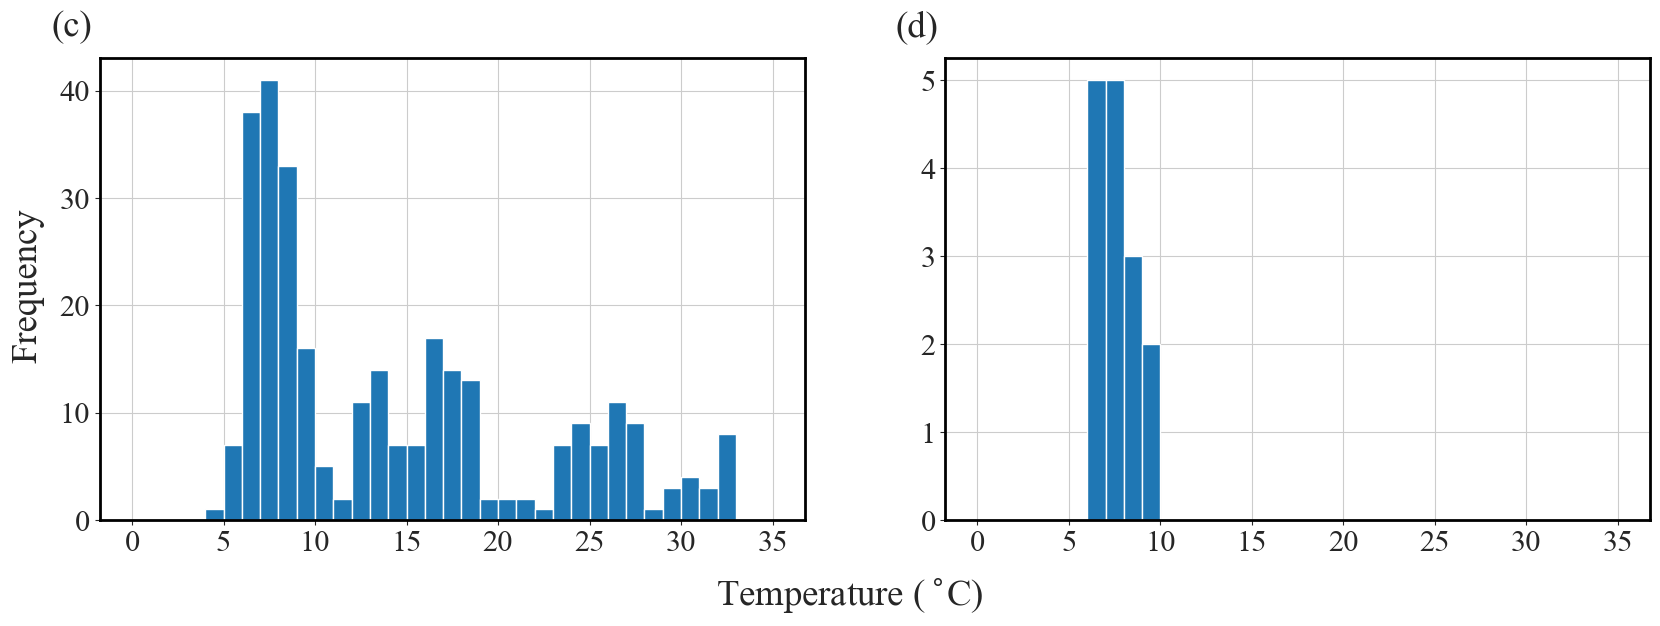

In [53]:
feature = 'Temp'
days=14
bins=range(0, 36, 1)
xticks=range(0, 36, 5)

chla_thresholds = [[50, np.inf],   # 50 이상
                   [100, np.inf]]  # 100 이상

fig, axes = plt.subplots(1, 2, figsize=(20, 6))#, sharey=True)
fig.supxlabel('Temperature (${}^\circ\! \mathdefault{C}$)', y=-0.05)
fig.supylabel('Frequency', x=0.08)
# fig.subplots_adjust(hspace=0.5)

abcd = ['(c)', '(d)']

for i, ax in enumerate(axes.flatten()):
    df = feature_fordays(feature_interval=chla_thresholds[i], days=days)

    ax.hist(df[feature], bins=bins)

    ax.set_xticks(xticks)

    ax.set_title(f'{abcd[i]}', y=1.03, x=-0.04)
    
plt.show()

- 수온 분포
- 클로로필-a 수치가 2주동안 평균 70 이상일 때와 100 이상일 때 비교

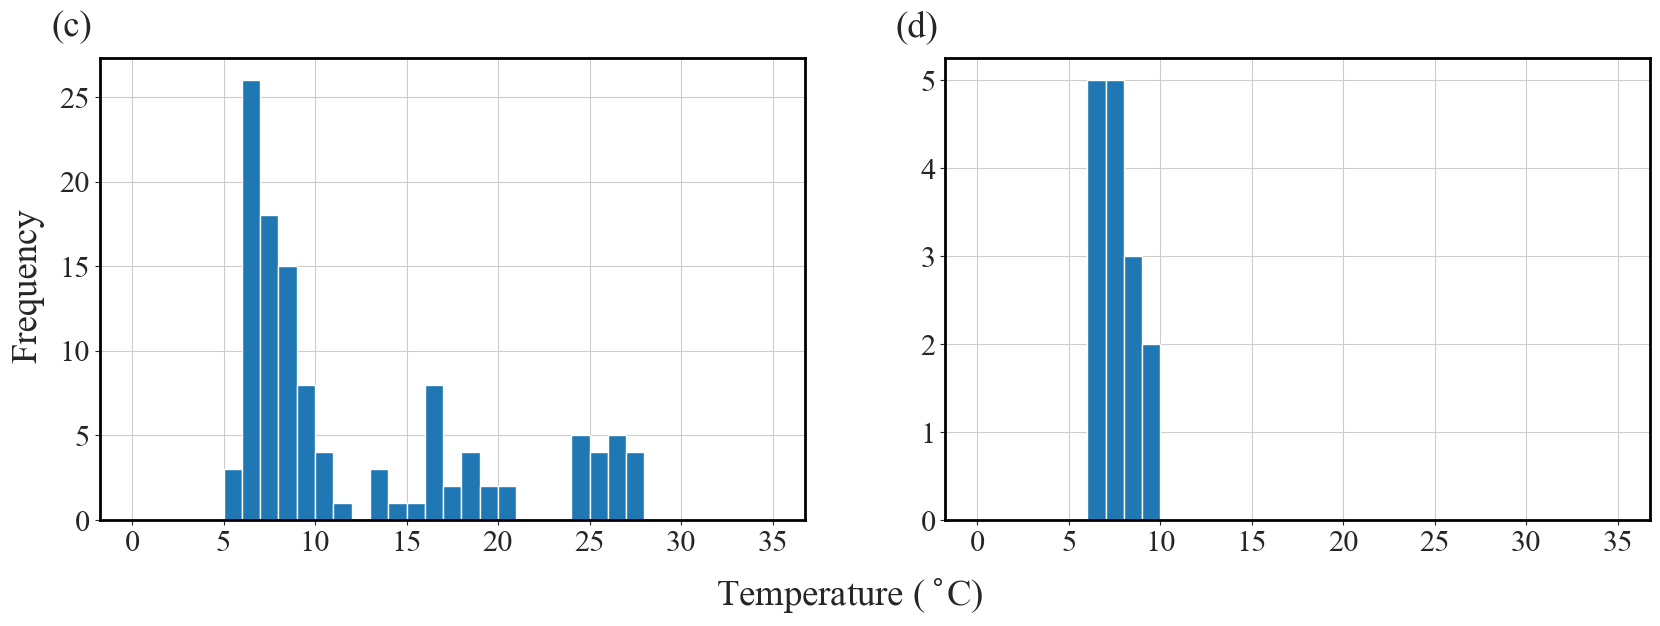

In [54]:
feature = 'Temp'
days=14
bins=range(0, 36, 1)
xticks=range(0, 36, 5)

chla_thresholds = [[70, np.inf],   # 70 이상
                   [100, np.inf]]  # 100 이상

fig, axes = plt.subplots(1, 2, figsize=(20, 6))#, sharey=True)
fig.supxlabel('Temperature (${}^\circ\! \mathdefault{C}$)', y=-0.05)
fig.supylabel('Frequency', x=0.08)
# fig.subplots_adjust(hspace=0.5)

abcd = ['(c)', '(d)']

for i, ax in enumerate(axes.flatten()):
    df = feature_fordays(feature_interval=chla_thresholds[i], days=days)

    ax.hist(df[feature], bins=bins)

    ax.set_xticks(xticks)

    ax.set_title(f'{abcd[i]}', y=1.03, x=-0.04)
    
plt.show()

- 방류량 분포
- 클로로필-a 수치가 2주동안 평균 20 이하일 때, 20 이상일 때, 70 이상일 때, 100 이상일 때 비교

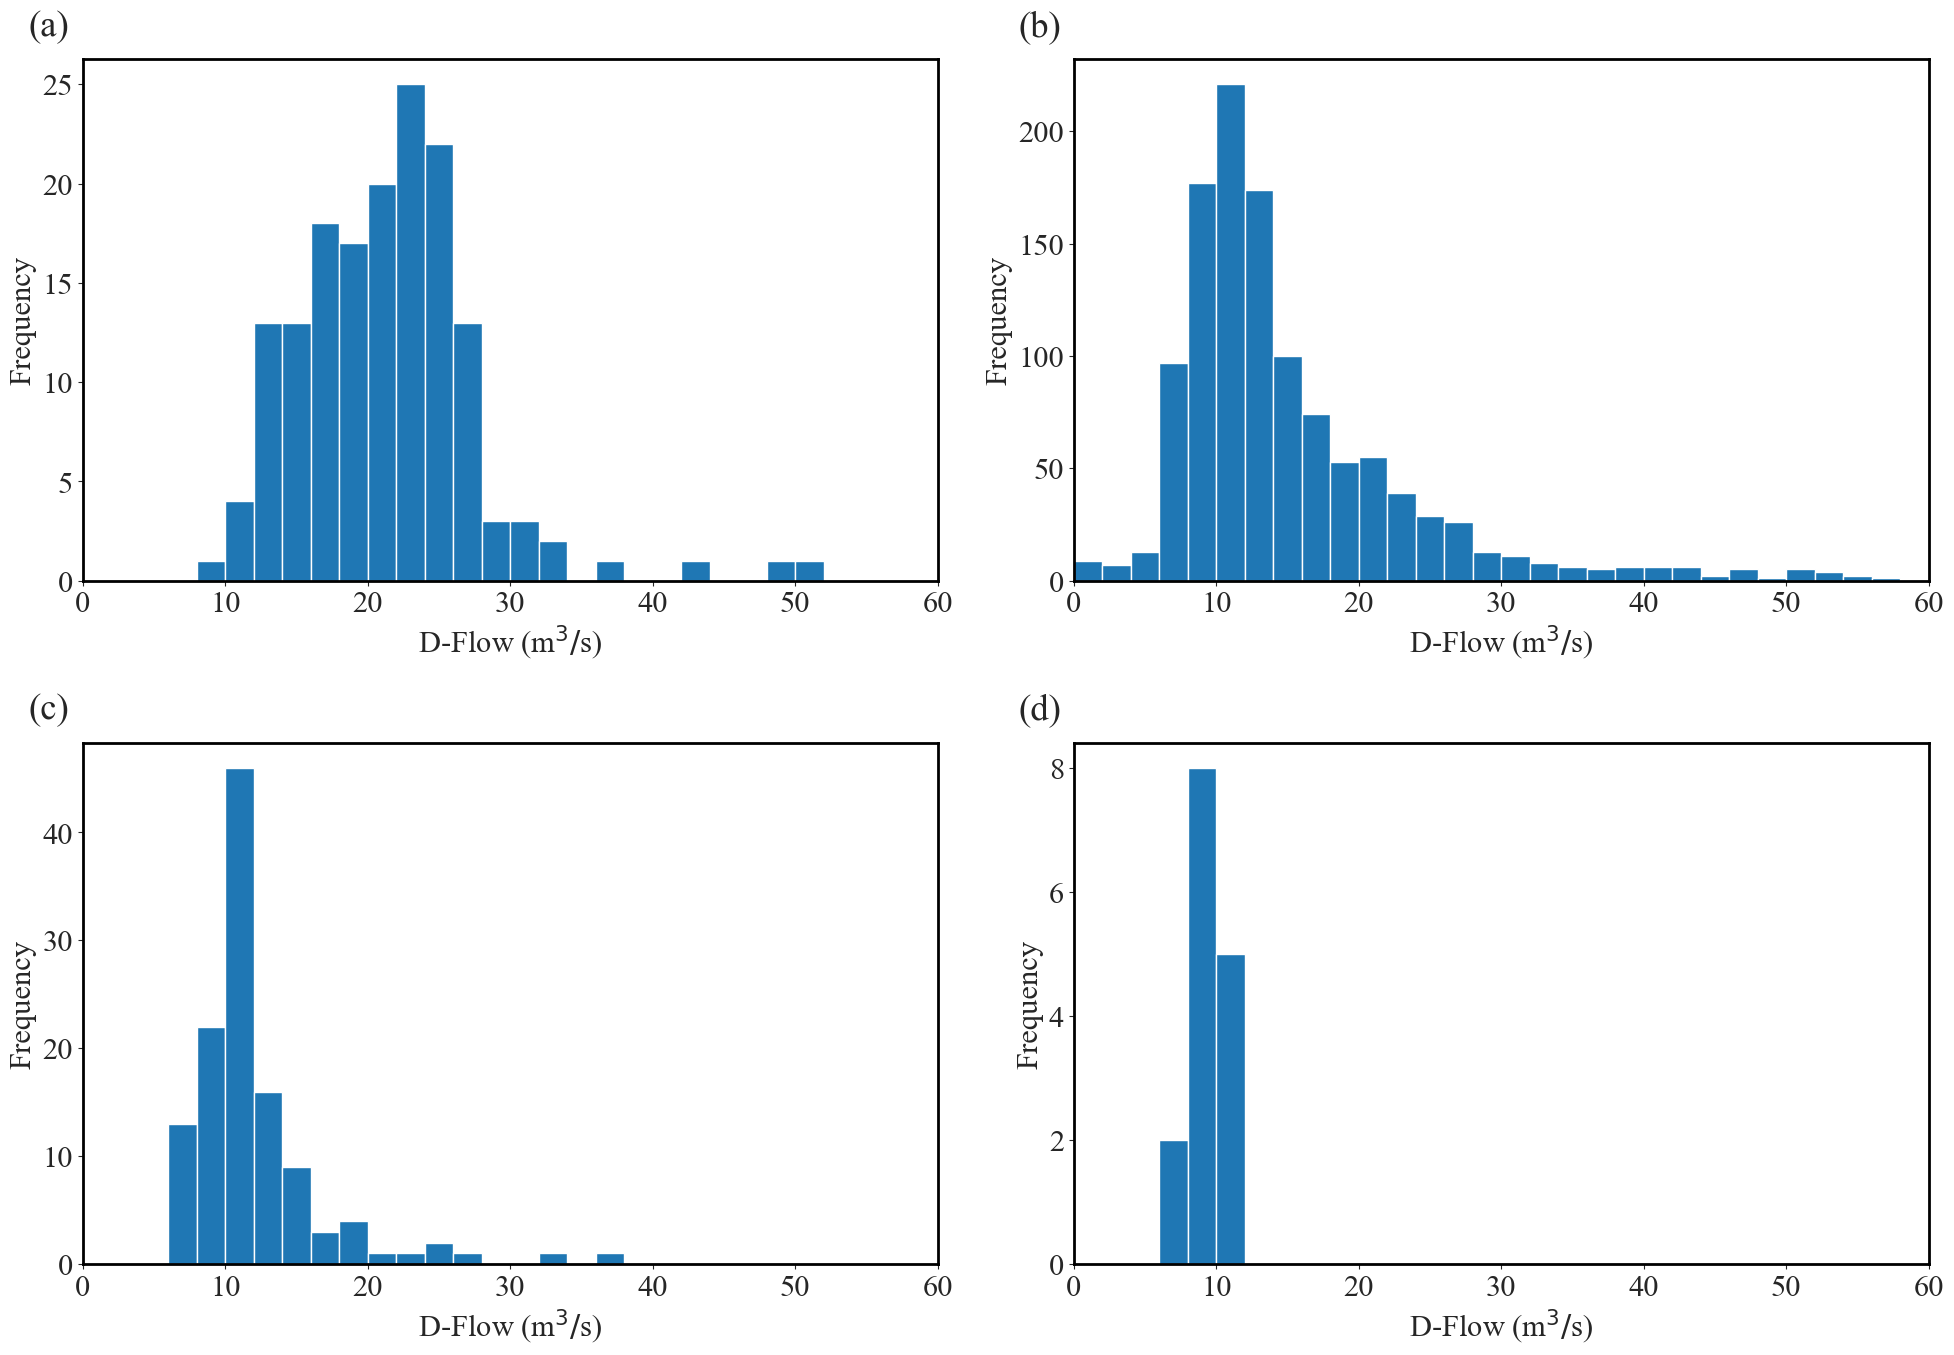

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
# fig.supxlabel('Discharge flow rate ($\mathdefault{m}^3/\mathdefault{s}$)', y=0.04)
# fig.supylabel('Frequency', x=0.08)
fig.subplots_adjust(hspace=0.3)

abcd = ['(a)', '(b)', '(c)', '(d)']

for i, ax in enumerate(axes.flatten()):
    feature = 'D-Flow'
    days=14
    bins=range(0, 61, 2)
    xticks=range(0, 61, 10)
    xlabel = 'D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)'

    chla_thresholds = [[0, 20], 
                       [20, np.inf],
                       [70, np.inf],
                       [100, np.inf]]

    df = feature_fordays(feature_interval=chla_thresholds[i], days=days)

    ax.hist(df[feature], bins=bins)

    ax.set_xticks(xticks)
    ax.set_xlabel(f'{xlabel}')
    ax.set_ylabel('Frequency')

    ax.set_xlim(0, xticks[-1])
    # ax.set_ylim(0, 95)


    ax.set_title(f'{abcd[i]}', y=1.03, x=-0.04)
    ax.grid(False)

save_fig('figure6')
plt.show()

- 수온 분포
- 클로로필-a 수치가 2주동안 평균 20 이하일 때, 20 이상일 때, 70 이상일 때, 100 이상일 때 비교

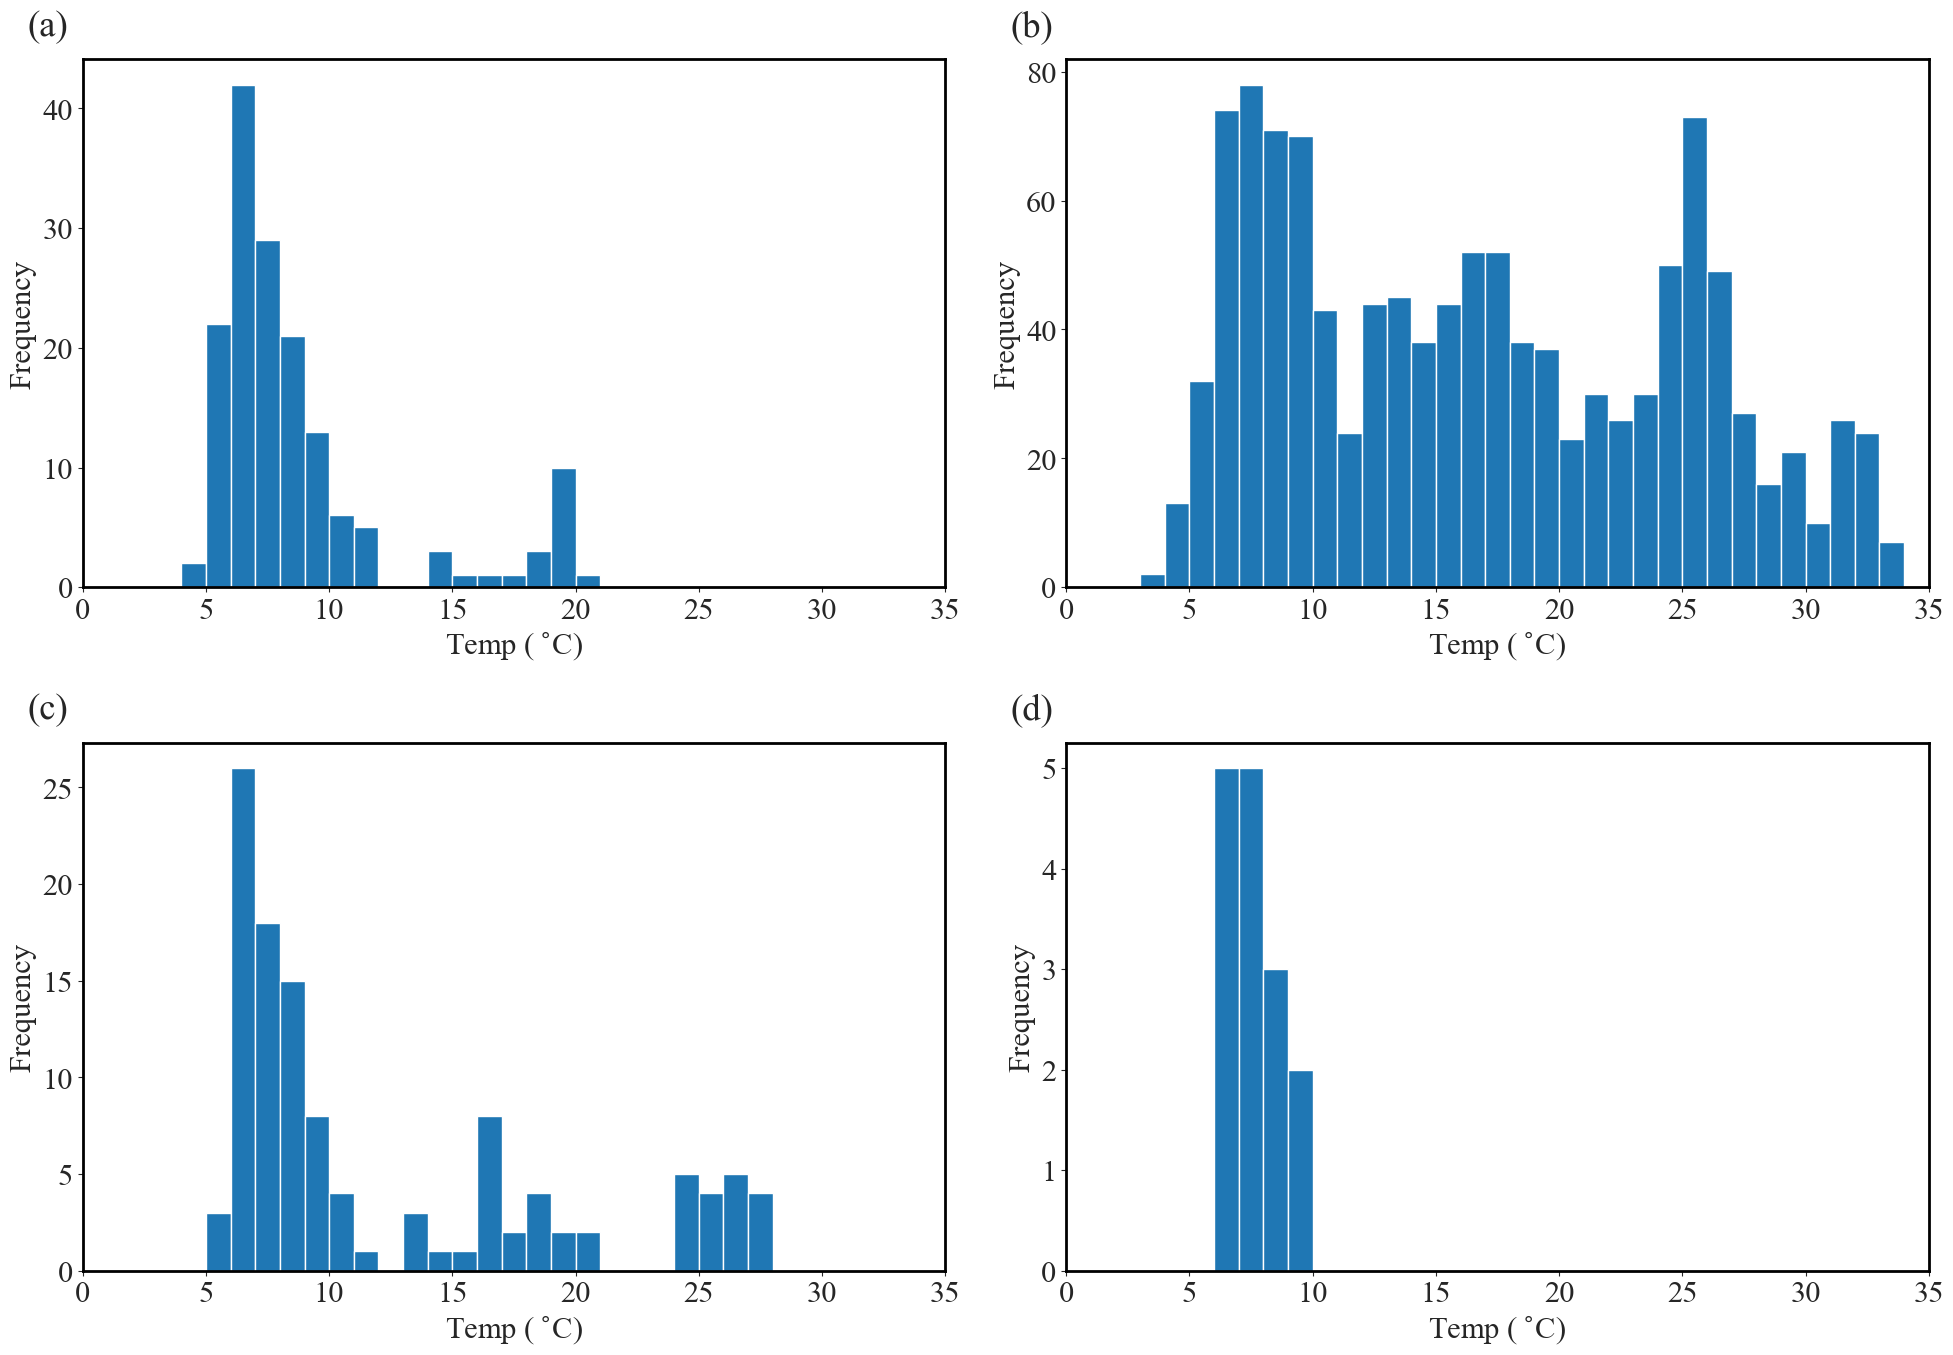

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
# fig.supxlabel('Discharge flow rate ($\mathdefault{m}^3/\mathdefault{s}$)', y=0.04)
# fig.supylabel('Frequency', x=0.08)
fig.subplots_adjust(hspace=0.3)

abcd = ['(a)', '(b)', '(c)', '(d)']

for i, ax in enumerate(axes.flatten()):
    feature = 'Temp'
    days=14
    bins=range(0, 36, 1)
    xticks=range(0, 36, 5)
    xlabel = 'Temp (${}^\circ\!$C)'

    chla_thresholds = [[0, 20], 
                       [20, np.inf],
                       [70, np.inf],
                       [100, np.inf]]

    df = feature_fordays(feature_interval=chla_thresholds[i], days=days)

    ax.hist(df[feature], bins=bins)

    ax.set_xticks(xticks)
    ax.set_xlabel(f'{xlabel}')
    ax.set_ylabel('Frequency')

    ax.set_xlim(0, xticks[-1])
    # ax.set_ylim(0, 95)

    ax.grid(False)
    ax.set_title(f'{abcd[i]}', y=1.03, x=-0.04)

save_fig('figureS3')
plt.show()

### 클로로필-a 농도 기준에 따른 특성들의 변화

클로로필-a 농도가 15, 25, 50, 100 이상 2주 이상 유지될 때의 방류량과 수온의 변화를 살펴본 과정을
보다 세분화하여 방류량과 수온의 변화의 연속성을 확인한다.
이를 위해 클로로필-a 농도의 기준값은 10부터 100까지의 구간 내에서 값을 5씩 키우며 다른 특성들의 변화를 살펴본다.

**`algal_alarm_level()` 함수**

클로로필-a 농도가 10부터 100 사이의 기준값 이상 `weeks` 주동안 지속될 때의 각 특성별 사분위수(기본값은 평균값)을 확인한다.

- `quartile='mean'`: 사분위수 지정. 기본은 평균값.

In [57]:
def algal_alarm_level(quartile='mean', weeks=2):

    day_quartile_dict = dict()

    for threshold in range(10, 101, 5):
        mask = scb_df_daily['Chl-a'].rolling(window=weeks*7).min() >= threshold
        desc = scb_df_daily[mask].describe()
        day_quartile = desc.loc[quartile]
        day_quartile_dict[threshold] = day_quartile

    day_quartile_df = pd.DataFrame(day_quartile_dict).T
    
    return day_quartile_df

클로로필-a 농도가 지정된 기준값 이상 2주동안 지속될 때 각 특성별 평균값의 변화는 다음과 같다.

In [58]:
day_quartile_df = algal_alarm_level(quartile='mean')
day_quartile_df

,Temp,EC,DO,TOC,TN,TP,Chl-a,Upstream,Downstream,Inflow,D-Flow
10,17.947644,359.108395,7.453648,4.609364,5.636368,0.118779,60.652574,6.800400,2.535053,20.221653,20.074640
15,17.344083,368.767635,7.913794,4.617135,5.800716,0.113522,65.327176,6.756246,2.465678,18.508541,18.339211
20,16.789464,377.187009,8.367161,4.640582,5.920785,0.111822,69.321608,6.678750,2.336811,17.142171,16.969273
25,16.363852,378.136313,8.549731,4.625165,5.979717,0.111937,73.168973,6.621113,2.263366,17.220013,17.021399
30,16.030472,380.085213,9.034202,4.638945,6.087446,0.109077,79.753048,6.505022,2.149508,16.795517,16.651541
35,16.361083,375.878402,9.163261,4.657112,6.100338,0.105522,85.207885,6.474581,2.101930,16.509336,16.353601
40,15.767567,383.022720,9.554727,4.675775,6.337922,0.102628,88.954035,6.404192,1.985288,15.488985,15.328770
45,15.281365,390.776062,9.692488,4.746682,6.506485,0.099711,92.275939,6.335273,1.873539,14.858196,14.765307
50,14.411360,400.709529,10.131253,5.004242,6.654920,0.101800,98.168148,6.218915,1.634005,13.355937,13.278674
55,14.318808,399.768800,10.228172,5.041080,6.747411,0.102648,101.487625,6.262543,1.491260,13.443512,13.338329


**특성별 변화 선그래프**

클로로필-a 수치가 지정된 기준값 이상 2주동안 지속될 때 각 특성별 평균값의 변화를 선 그래프로 그리면 다음과 같다.

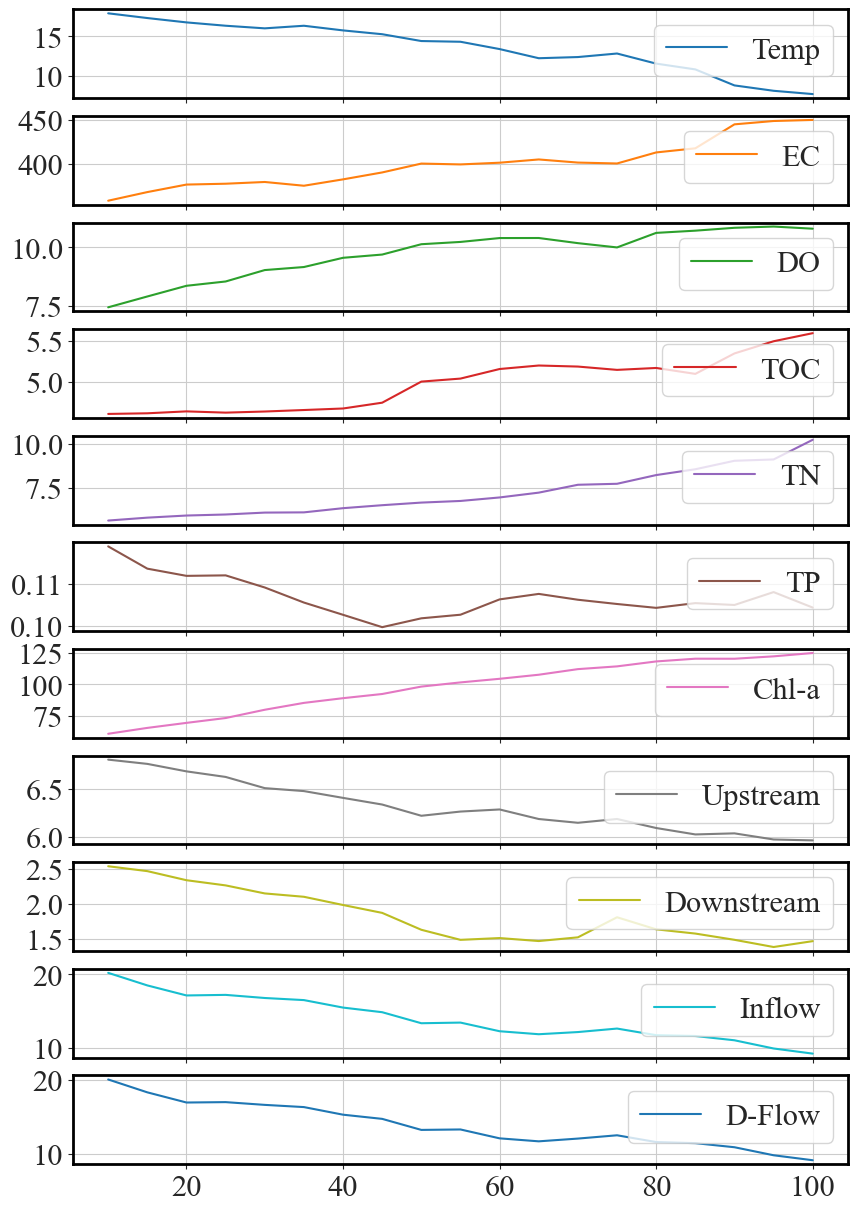

In [59]:
axes = day_quartile_df.plot(subplots=True, figsize=(10, 15))

# 범례 위치 지정
for ax in axes:
    ax.legend(loc='upper right')

**특성 변화 분석**

특성별 수치 변동의 사분위수는 다음과 같다.

In [60]:
day_quartile_df.describe()

,Temp,EC,DO,TOC,TN,TP,Chl-a,Upstream,Downstream,Inflow,D-Flow
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,13.588882,399.835034,9.729698,4.982152,7.180502,0.106819,97.812392,6.313163,1.828439,13.997668,13.884025
std,3.152113,26.171127,1.041162,0.322009,1.315301,0.004596,20.854389,0.263735,0.376553,3.065926,3.027311
min,7.643970,359.108395,7.453648,4.609364,5.636368,0.099711,60.652574,5.963903,1.389686,9.214315,9.191514
25%,11.874850,379.110763,9.098732,4.648847,6.093892,0.104300,82.480466,6.119204,1.504193,11.793333,11.690192
50%,14.318808,400.709529,10.131253,5.041080,6.747411,0.105522,101.487625,6.262543,1.640275,13.355937,13.278674
75%,16.195778,409.266180,10.503382,5.179356,7.968461,0.108533,116.200669,6.489801,2.125719,16.652426,16.502571
max,17.947644,449.625154,10.880924,5.595887,10.217116,0.118779,124.862947,6.800400,2.535053,20.221653,20.074640


아래 표는 특성별 수치 변동을 요약한다.

| Features | Explanation |
| :---: | :--- |
| Temp | 높은 Chl-a가 오래 지속될 수록 평균 수온이 계속 떨어짐. 이유는 동절기에 방류량이 매우 적어서 Chl-a 수치가 높게 유지되기 때문으로 판단됨.|
| EC | 큰 변화 없음. std=26.17가 mean=399.83의 6.5% 수준. 하지만 높은 Chl-a가 오래 지속될 수록 높아짐. 강우량과 연관되어 있는 것으로 알려짐. (Kang et al, 2019) |
| DO | 큰 변화 없음. std=1.04가 mean=9.73의 10.7% 수준. 하지만 높은 Chl-a가 오래 지속될 수록 높아짐. 이유는 불명확함. 하지만 별로 중요해 보이지 않음. 이유는 호소수 수질환경기준에 따르면 DO 농도는 매우 좋음이 유지되기 때문임. |
| TOC | 거의 변화 없음. std=0.32가 mean=4.98의 4.1% 수준. 하지만 높은 Chl-a가 오래 지속될 수록 조금 높아지는 경향 보임. 하지만 별로 중요해 보이지 않음. 이유는 호소수 수질환경기준에 따르면 TOC 농도는 보통 수준이 유지되기 때문임.|
| TN | min=5.64, max=10.22 정도. 높은 Chl-a가 오래 지속될 수록 TN이 두 배정도 높아짐. 하지만 별로 중요해 보이지 않음. 이유는 호소수 수질환경기준에 따르면 TN 농도는 매우 나쁨보다 훨씬 나쁜 수준이 유지되기 때문임.|
| TP | 거의 변화 없음. std=0.0045가 mean=0.1068의 4.3% 수준. 이유는 총인 처리시설 때문([Seo et al., 2018] 참고). 하지만 높은 Chl-a가 오래 지속될 수록 조금 낮아지는 경향 보임. 하지만 별로 중요해 보이지 않음. 이유는 호소수 수질환경기준에 따르면 TP 농도는 약간 나쁨 수준이 유지되기 때문임.|
| Chl-a | max=124.86, min=60.65 정도. 높은 Chl-a가 오래 지속될 수록 평균 수온이 계속 떨어짐. 이유는 동절기에 방류량이 매우 적어서 Chl-a 수치가 높게 유지되기 때문으로 판단됨. |
| Upstream |  거의 변화 없음. std=0.26가 mean=6.31의 4.2% 수준. 하지만 높은 Chl-a가 오래 지속될 수록 조금 낮아지는 경향 보임. 상류 높이 최대한 동일하게 유지하기 때문. 또한 수온 또한 낮아지기에 동절기 유입량이 적기 때문으로 판단됨. |
| Downstream |  거의 변화 없음. std=0.38가 mean=1.83의 4.2% 수준. 하지만 높은 Chl-a가 오래 지속될 수록 조금 낮아지는 경향 보임. 수온 또한 낮아지기에 동절기 유입량이 적기 때문으로 판단됨. |
| Inflow | max=20.24, min=9.21 정도. 높은 Chl-a가 오래 지속될 수록 유입량이 절반 이하로 줄어듦. 수온 또한 낮아지기에 동절기 유입량이 적기 때문으로 판단됨. |
| Discharge | max=20.08, min=9.19 정도. 높은 Chl-a가 오래 지속될 수록 유입량이 절반 이하로 줄어듦. 수온 또한 낮아지기에 동절기 유입량이 적기 때문으로 판단됨. |

핵심은 다음과 같다.

- Temp: 높은 Chl-a가 오래 지속될 수록 평균 수온이 계속 떨어짐. 이유는 동절기에 방류량이 매우 적어서 Chl-a 수치가 높게 유지되기 때문으로 판단됨.
- EC, DO, TOC, Upstream, Downstream 등의 수치 변동은 크지 않음.
- TN: 클로로필-a 값이 높게 오래 지속될 수록 높아짐. 하지만 별로 중요해 보이지 않음. 이유는 호소수 수질환경기준에 따르면 TN 농도는 매우 나쁨보다 훨씬 나쁜 수준이 유지되기 때문임.
- TP: 거의 변화 없음. 이유는 총인 처리시설 때문임. 그리고 별로 중요해 보이지 않음. 이유는 호소수 수질환경기준에 따르면 TP 농도는 약간 나쁨 수준이 유지되기 때문임. 
- Inflow와 Discharge: 거의 동일하게 변함. 하지만 방류량이 클로로필-a의 농도에 보다 많은 영향을 준다는 기존 연구에 따라 Discharge에 집중함.


**N/P 비율**

[Shin et al., 2003; Reynolds, 1984]에 따르면 N/P 비율이 낮아질 수록, 즉 인(Phosphorus)의 유입이
늘어날 수록 남조류의 출현시기가 빨라지고 우점기간이 늘어나서 결국 클로로필-a의 농도가 빠르게 올라간다.
따라서 TN/TP의 비율의 변화를 살펴보는 것도 의미있다.

In [61]:
day_quartile_df['TN/TP'] = day_quartile_df['TN'] / day_quartile_df['TP']

In [62]:
day_quartile_df['TN/TP'].describe()

count    19.000000
mean     67.517198
std      13.500368
min      47.452671
25%      56.810049
50%      65.372542
75%      76.101975
max      97.928409
Name: TN/TP, dtype: float64

TN/TP의 min=47.45에서 max=97.93 정도로 변한다. 
아래 그래프에서 볼 수 있듯이 클로로필-a의 수치가 2주 이상 높게 유지될 수록 
TN/TP가 증가한다.
이는 앞서 언급한 두 논문에서의 설명과 상반되는 결과이다.
[Seo et al., 2018]에서 이미 영산간 보 구간의 조류발생 패턴은 일반적으로 알려진 N/P 비율에 의한 것과는
다른 수 환경 요인에 의해 결정되는 것 같다고 추론 하였다. 

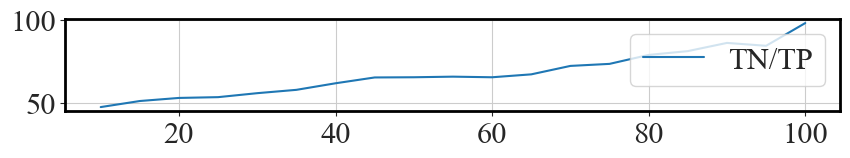

In [63]:
axes = day_quartile_df['TN/TP'].plot(subplots=True, figsize=(10, 1.2))

# 범례 위치 지정
for ax in axes:
    ax.legend(loc='upper right')

### 수온, 방류량, 클로로필-a 의 관계

아래 그래프는 클로로필-a의 수치가 일정 기준값보다 높게 2주 이상 유지될 때의 수온과 방류량의 변화만 따로 살펴본다. 클로로필-a의 기준값이 높아질수록 수온과 방류량의 평균값이 동반하락함을 보여준다. [Shin et al, 2003]에 따르면 강수량과 유량을 중심으로 하는 물리적 수문요인이 수 환경의 변화에 주는 영향이 매우 중요하다. 한국의 동절기에는 강우량이 매우 적기에 이는 결국 유량의 중요도가 보다 높아짐을 의미한다. 따라서 한국의 동절기에 유량이 매우 적어지면 수온이 상대적으로 매우 낮음에도 불구하고 클로로필-a의 수치가 높아지는 주요 원인이라고 판단된다. 

/tmp/ipykernel_17972/2512521663.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


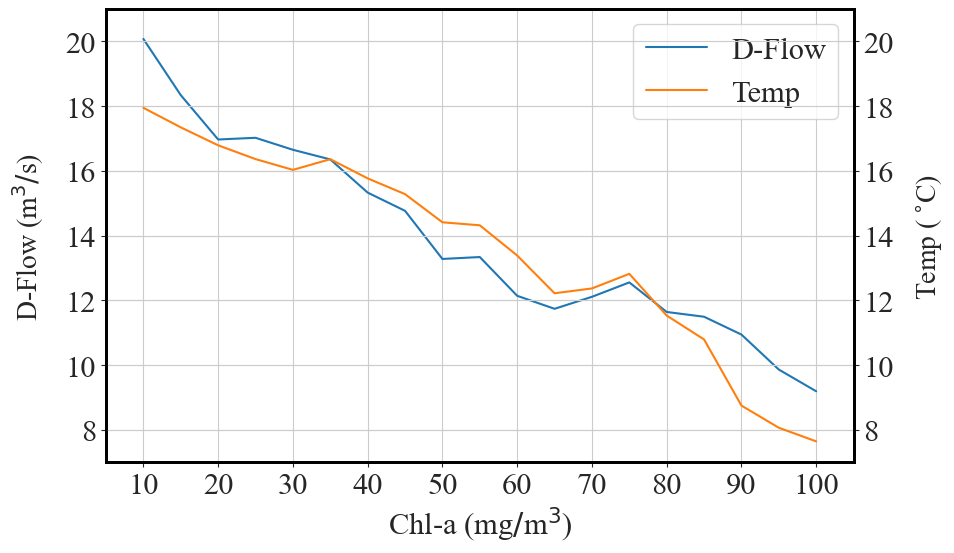

In [64]:
import matplotlib

df = day_quartile_df[['Temp', 'D-Flow']].reset_index().rename(columns={'index':'Chl-a'})
x_column = 'Chl-a'
columns = [['D-Flow'], ['Temp']]

cmap = matplotlib.colormaps['tab10']

fig, ax = plt.subplots()

axes = [ax]
handles = []

for i, _ in enumerate(range(len(columns) - 1)):
    twin = ax.twinx()
    axes.append(twin)
    twin.spines.right.set_position(("axes", 1 + i/10))

j = 0
for i, col in enumerate(columns):
    ylabel = []
    
    if len(col) == 1:
        p, = axes[i].plot(df[x_column], df[col[0]], label = col[0], color = cmap(j)[:3])
        ylabel.append(col[0])
        handles.append(p)
        j += 1
    else:
        for sub_col in col:
            p, = axes[i].plot(df[x_column], df[sub_col], label = sub_col, color = cmap(j)[:3])
            ylabel.append(sub_col)
            handles.append(p)
            j += 1

    # axes[i].set_ylabel(', '.join(ylabel))
    if i == 0:
        axes[i].set_ylabel('D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)', fontsize=20, x=1, labelpad=15)
    else:
        axes[i].set_ylabel('Temp (${}^\circ\! \mathdefault{C}$)', fontsize=20, x=1, labelpad=15)

    axes[i].set_yticks(range(8,21,2))
    axes[i].set_ylim(7,21)


ax.legend(handles = handles, frameon = True)
ax.set_xticks(range(0, 101, 10))
ax.set_xlim(5, 105)
ax.set_xlabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')

plt.tight_layout()

save_fig('figure7c')
plt.show()

## 계절별 방류량에 따른 클로로필-a의 변화

방류량이 일정 기간동안 특정 구간에 머무를 때 클로로필-a의 변화를 살펴본다. 
방류량 구간 기준점을 정하기 위해 먼저 사분위수와 백분위수를 확인한다.

- 승촌보 방류량 사분위수

In [65]:
scb_df_daily['D-Flow'].describe().loc['min':]

min       0.000000
25%      11.475920
50%      16.495660
75%      25.999184
max    3262.507857
Name: D-Flow, dtype: float64

- 승촌보 방류량 백분위수: 80%, 85%, 90%, 95%에 해당하는 방류량 수치

In [66]:
scb_df_daily['D-Flow'].quantile(np.arange(0.80, 1, 0.05))

0.80    29.062653
0.85    34.992448
0.90    47.773958
0.95    88.911385
Name: D-Flow, dtype: float64

이를 바탕으로 방류량 구간의 기준점을 다음과 같이 정한다.

```
[0, 11.5, 16.5, 26, 40, 50, 60, 70, 80, 90, 100]
```

**min_level_fordays() 함수**

주어진 데이터셋 `df`를 대상으로, `feature` 특성을 기준으로 특성값이 
`bins` 구간에 `days` 일동안 유지될 때의 온도와 클로로필-a의 `quartile` 변화를 반환한다.

- `df`: 데이터셋 데이터프레임
- `feature='D-Flow'`: 대상 특성. 기본값은 방류량.
- `quartile='mean'`: 특성별 사분위수 구하기. 기본값은 평균값.
- `days=1`: 대상 특성값의 구간 지속 기간. 기본값은 1일.
- ` bins=[0, 11.5, 16.5, 26, 50, 70, 90]`: 대상 특성값의 구간 구분 기준. 기본값은 방류량 구간 구분.
- `targets=None`: 보여주고자 하는 변화 대상 특성들의 리스트 지정. 기본값은 `None`

In [67]:
def min_level_fordays(df, feature='D-Flow', quartile='mean', days=1,  bins=[0, 11.5, 16.5, 26, 40, 50, 60, 70, 80, 90, 100], targets=None):

    day_quartile_dict = dict()

    for idx in range(0, len(bins)-1):
        # feature가 지정된 구간에서 days 일동안 유지되는 날짜만 대상
        mask = (df[feature].rolling(window=days).min() > bins[idx]) & (df[feature].rolling(window=days).max() <= bins[idx+1])
        desc = df[mask].describe()
        day_quartile = desc.loc[quartile]
        
        # feature 특성값은 언제나 mean 선택
        # day_feature_mean = desc.loc['mean'][feature]
        # day_quartile[feature] = day_feature_mean

        day_quartile_dict[bins[idx]] = day_quartile

    # 마지막 구간은 최대값 이상을 대상으로 함.
    day_quartile_dict[bins[-1]] = df[df[feature].rolling(window=days).min() >= bins[-1]].describe().loc[quartile]
    day_quartile_df = pd.DataFrame(day_quartile_dict).T

    # 지정된 특성만 선택해서 반환
    if targets != None:
        return day_quartile_df[targets]
    else:
        return day_quartile_df

### 계절별 변화

**계절 데이터셋**

클로로필-a의 농도가 방류량과 함께 수온에 의존하는 것으로 판단된다.
따라서 계절별로 방류량을 기준으로 클로로필-a의 변화를 살펴본다.
아래 코드는 계절별 데이터셋을 지정한다.

| 계절 | 기간 |
| :---: | :---: |
| 봄 | 3월, 4월, 5월 |
| 여름 | 6월, 7월, 8월 |
| 가을 | 9월, 10월, 11월 |
| 겨울 | 12월, 1월, 2월 |

In [68]:
spring_scb_df_daily = scb_df_daily.loc[scb_df_daily.index.to_series().dt.month.apply(lambda x: x in [3, 4, 5])]
summer_scb_df_daily = scb_df_daily.loc[scb_df_daily.index.to_series().dt.month.apply(lambda x: x in [6, 7, 8])]
fall_scb_df_daily = scb_df_daily.loc[scb_df_daily.index.to_series().dt.month.apply(lambda x: x in [9, 10, 11])]
winter_scb_df_daily = scb_df_daily.loc[scb_df_daily.index.to_series().dt.month.apply(lambda x: x in [12, 1, 2])]

**seasonal_min_level_fordays() 함수**

계절별로 `days`일 동안 방류량이 일정하게 유지될 때의 `targets` 특성 변화를 담은 데이터프레임을 생성한다.
기본값으로 방류량이 일정하게 1일 동안 유지될 때의 클로로필-a의 농도를 계절별로 계산한다.

In [69]:
def seasonal_min_level_fordays(days=1, targets=['Chl-a']):
    df = pd.DataFrame()

    for season in ['spring', 'summer', 'fall', 'winter']:
        df[season] = min_level_fordays(eval(season+'_scb_df_daily'), days=days, targets=['Chl-a'])

    return df

**방류량이 1일동안 일정 기준 이상 유지될 때의 클로로필-a 변화**

계절별로 초당 방류량의 평균값이 하룻동안 일정 구간에 머무를 때의 클로로필-a의 변화는 다음과 같다.
콜로로필-a 기준으로 보통의 수질을 유지하기 위한 초당 방류량은 대략적으로 다음과 같다.
호소수의 수질환경기준에서 클로로필-a의 농도는 20 $\text{mg}$/$\text{m}^3$ 이하일 때 수질이 '보통'으로 판정된다.


| 계절 | 평균 방류량 |
| :---: | :--: |
| 봄 | 95 |
| 여름 | 85 |
| 가을 | 40 |
| 겨울 | 20 | 

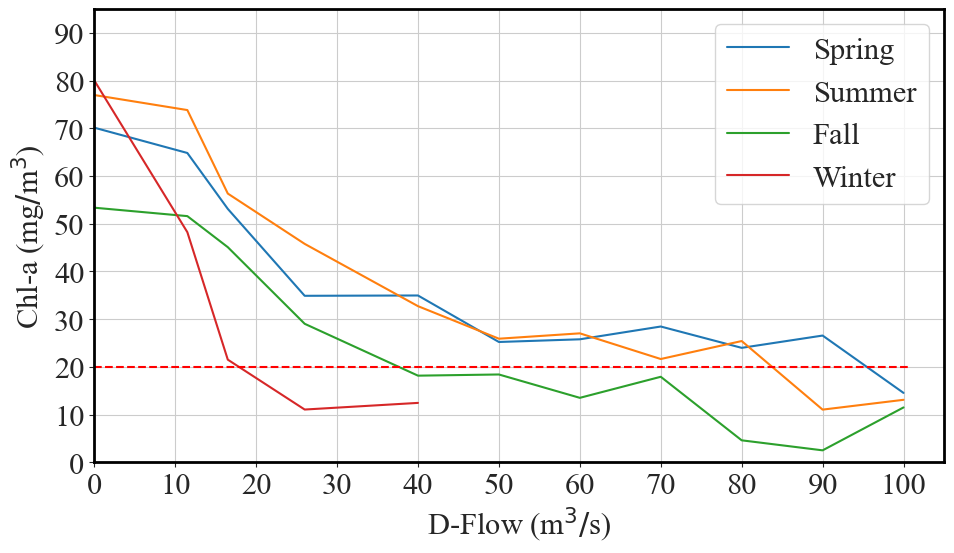

In [70]:
days = 1

ax = seasonal_min_level_fordays(days=days).plot(figsize=(10, 6))

# ax.set_xticks(range(0, 101, 10))

# 20 mg/m3 기준선 추가
xs = np.arange(0, 101, 0.1)
ys = np.array([20]*len(xs))
ax.plot(xs, ys, 'r--')

ax.set_xlabel('D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)')
ax.set_ylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')

ax.set_xticks(range(0, 101, 10))
ax.set_yticks(range(0, 101, 10))

ax.set_xlim(0, 105)
ax.set_ylim(0, 95)

ax.legend(['Spring', 'Summer', 'Fall', 'Winter'])


# ax.set_title(f'Seasonal Chl-a level for {days} day(s) depending on discharge')

save_fig(f"figure-abstract")
plt.show()


**방류량이 2일동안 일정 기준 이상 유지될 때의 클로로필-a 변화**

계절별로 초당 방류량의 평균값이 이틀 연속 일정 구간에 머무를 때의 클로로필-a의 변화는 다음과 같다.
콜로로필-a 기준으로 보통의 수질을 유지하기 위한 초당 방류량은 대략적으로 다음과 같다.

| 계절 | 평균 방류량 |
| :---: | :--: |
| 봄 | 30 |
| 여름 | 60 |
| 가을 | 35 |
| 겨울 | 15 | 

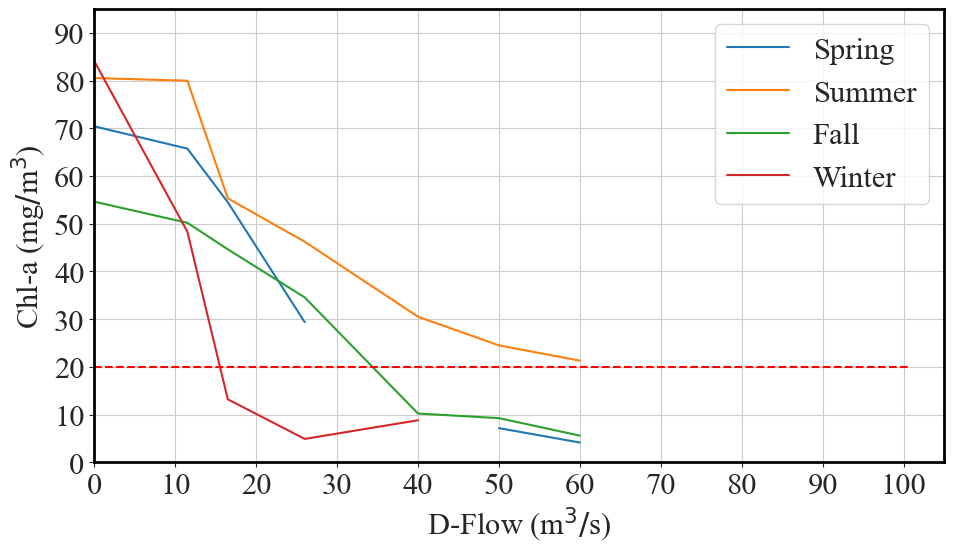

In [71]:
days = 2

ax = seasonal_min_level_fordays(days=days).plot(figsize=(10, 6))

# ax.set_xticks(range(0, 101, 10))

# 20 mg/m3 기준선 추가
xs = np.arange(0, 101, 0.1)
ys = np.array([20]*len(xs))
ax.plot(xs, ys, 'r--')

ax.set_xlabel('D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)')
ax.set_ylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')

ax.set_xticks(range(0, 101, 10))
ax.set_yticks(range(0, 101, 10))

ax.set_xlim(0, 105)
ax.set_ylim(0, 95)

ax.legend(['Spring', 'Summer', 'Fall', 'Winter'])

# ax.set_title(f'Seasonal Chl-a level for {days} day(s) depending on discharge')

save_fig(f"seasonal_chla_{days}d_discharge")
plt.show()


비교를 위해 하나의 그래프로 그린다.

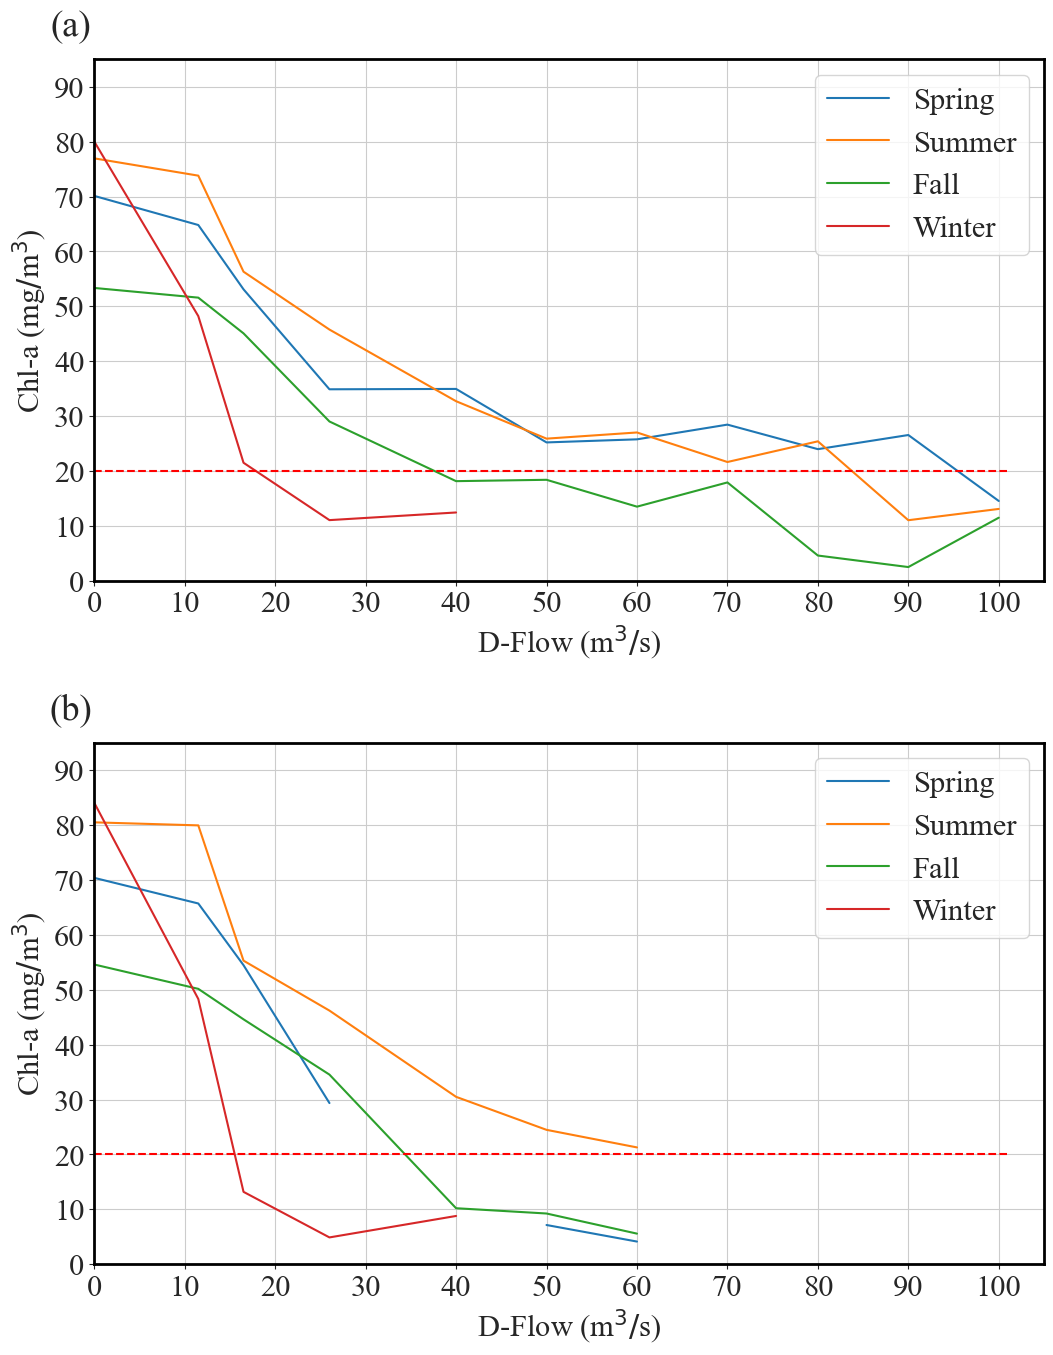

In [72]:
days = [1, 2]

fig, axes = plt.subplots(2, 1, figsize=(11, 14))#, sharey=True)
# fig.supxlabel('Discharge flow rate ($\mathdefault{m}^3/\mathdefault{s}$)', y=-0.05)
# fig.supylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)', x=0.08)
fig.subplots_adjust(hspace=0.3)

abcd = ['(a)', '(b)']

yticks = np.arange(0, 101, 20)

for i, ax in enumerate(axes.flatten()):
    df = seasonal_min_level_fordays(days=days[i])

    ax.plot(df)
    ax.legend(df.columns, fontsize=24)

    xs = np.arange(0, 101, 0.1)
    ys = np.array([20]*len(xs))
    ax.plot(xs, ys, 'r--')


    ax.set_xticks(range(0, 101, 10))
    ax.set_yticks(range(0, 101, 10))

    ax.set_xlim(0, 105)
    ax.set_ylim(0, 95)

    ax.legend(['Spring', 'Summer', 'Fall', 'Winter'])

    ax.set_xlabel('D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)')
    ax.set_ylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)', x=0.08)

    ax.set_title(f'{abcd[i]}', y=1.03, x=-0.025)
    # ax.set_title(f'{abcd[i]} Chl-a level for {days[i]} day(s)', y=1.03)

save_fig('figure8a')
plt.show()

## 수온과 방류량에 따른 클로로필-a 수치 변화

수온과 방류량의 구간별 클로로필-a의 수치 변화를 추적한다. 

- 수온 구간

In [73]:
temp_bins = [0, 10, 15, 20, 25, 30]

- 방류량 구간

In [74]:
discharge_bins = [0, 11.5, 16.5, 26, 40, 50, 60, 70, 80, 90, 100]

* 지정된 수온 구간과 방류량 구간이 `days` 이상 지속되었을 때 클로로필-a 수치 평균값으로 구성된 데이터프레임 생성 함수

In [75]:
def discharge_temp_corr(discharge_bins, temp_bins, days=1, target='Chl-a'):
    target_df = pd.DataFrame()

    for idx in range(0, len(temp_bins)-1):
        mask = (scb_df_daily['Temp'] > temp_bins[idx]) & (scb_df_daily['Temp'] <= temp_bins[idx+1])
        temp_scb_daily = scb_df_daily[mask]

        quartile_level = min_level_fordays(temp_scb_daily, days=days, bins=discharge_bins)
        
        # 온도 구간 표시
        target_series = quartile_level[target].rename(f'{temp_bins[idx]}', inplace=True)
        
        target_df = pd.concat([target_df, target_series], axis=1)

    # 마지막 구간 지정
    mask = scb_df_daily['Temp'] > temp_bins[-1]
    temp_scb_daily = scb_df_daily[mask]

    quartile_level = min_level_fordays(temp_scb_daily, days=days, bins=discharge_bins)

    target_series = quartile_level[target].rename(temp_bins[-1], inplace=True)

    target_df = pd.concat([target_df, target_series], axis=1)

    return target_df

**방류량이 1일동안 일정 기준 이상 유지될 때의 클로로필-a 변화**

수온 구간별로 초당 방류량의 평균값이 이틀 연속 일정 구간에 머무를 때의 클로로필-a의 변화는 다음과 같다.
방류량이 20 이상일 때 클로로필-a의 농도가 20에서 30 사이 구간에서 진동을 많이 한다.
하루 정도 방류량을 조절하는 것으로는 클로로필-a의 농도를 제한하는 일이 어려움을 반영하는 것으로 보인다.
온도와 방류량 이외에 다른 요소가 클로로필-a의 농도에 영향을 줄 수도 있다.


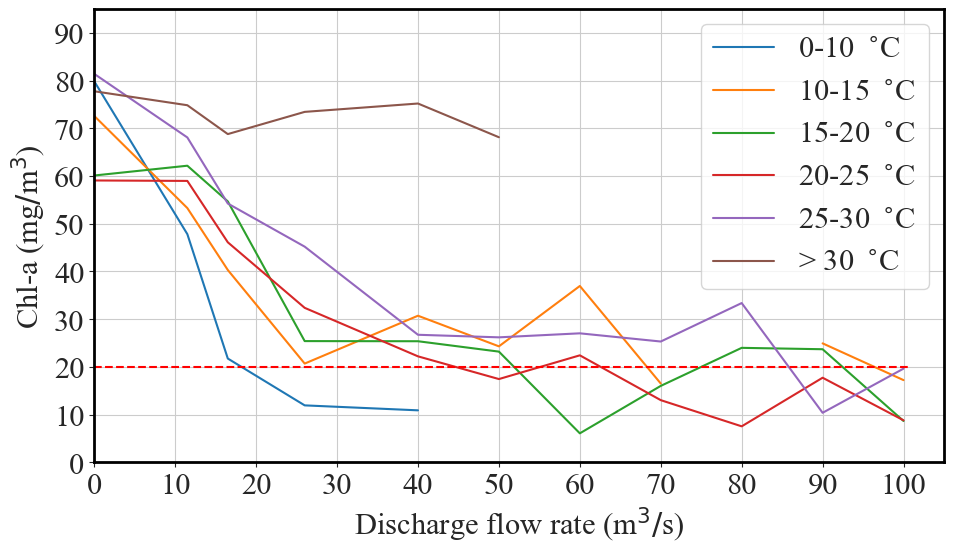

In [76]:
days = 1

ax = discharge_temp_corr(discharge_bins, temp_bins, days=days, target='Chl-a').plot(figsize=(10, 6))

# 20 mg/m3 기준선 추가
xs = np.arange(0, 101, 0.1)
ys = np.array([20]*len(xs))
ax.plot(xs, ys, 'r--')

ax.set_xlabel('Discharge flow rate ($\mathdefault{m}^3/\mathdefault{s}$)')
ax.set_ylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
# ax.set_title(f'Chl-a level for {days} day(s) depending on discharge and temperature')
ax.legend([f'{temp_bins[i]}-{temp_bins[i+1]} $^\circ\!$C' for i in range(len(temp_bins)-1)] + [f'> {temp_bins[-1]} $^\circ\!$C'])

ax.set_xticks(range(0, 101, 10))
ax.set_yticks(range(0, 101, 10))

ax.set_xlim(0, 105)
ax.set_ylim(0, 95)

save_fig(f"thermal_chla_{days}d_discharge")
plt.show()

**방류량이 2일동안 일정 기준 이상 유지될 때의 클로로필-a 변화**

수온 구간별로 초당 방류량의 평균값이 이틀 연속 일정 구간에 머무를 때의 클로로필-a의 변화는 다음과 같다.
방류량이 어느 정도 이상 이틀 정도 지속되면 클로로필-a의 농도가 상당히 내려간다. 
콜로로필-a 기준으로 보통의 수질을 유지하기 위한 초당 방류량은 대략적으로 다음과 같다.

| 평균 수온 | 평균 방류량 |
| :---: | :--: |
| 0-10 | 15 |
| 10-15 | 25 |
| 15-20 | 25 |
| 20-25 | 35 |
| 25-30 | 60 | 
| 30- | unkown | 

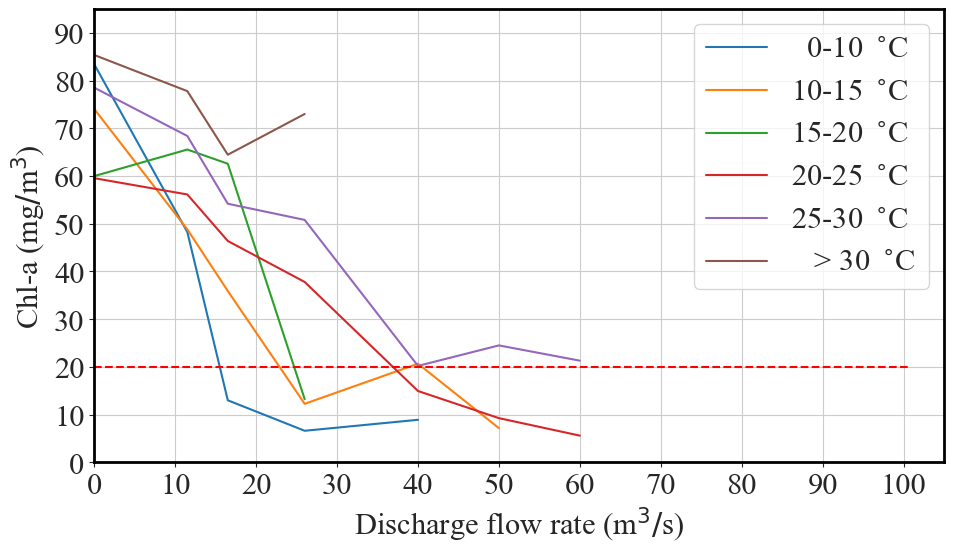

In [77]:
days = 2

ax = discharge_temp_corr(discharge_bins, temp_bins, days=days, target='Chl-a').plot(figsize=(10, 6))

# 20 mg/m3 기준선 추가
xs = np.arange(0, 101, 0.1)
ys = np.array([20]*len(xs))
ax.plot(xs, ys, 'r--')

ax.set_xlabel('Discharge flow rate ($\mathdefault{m}^3/\mathdefault{s}$)')
ax.set_ylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
# ax.set_title(f'Chl-a level for {days} day(s) depending on discharge and temperature')
ax.legend(['%5s $^\circ\!$C' % ('  '+str(temp_bins[i])+'-'+str(temp_bins[i+1])) if i==0 \
           else '%5s $^\circ\!$C' % (str(temp_bins[i])+'-'+str(temp_bins[i+1])) for i in range(len(temp_bins)-1)] \
            + ['%5s $^\circ\!$C' % ('   > '+str(temp_bins[-1]))])

ax.set_xticks(range(0, 101, 10))
ax.set_yticks(range(0, 101, 10))

ax.set_xlim(0, 105)
ax.set_ylim(0, 95)


save_fig(f"thermal_chla_{days}d_discharge")
plt.show()

비교를 위해 하나의 그래프로 그린다.

In [78]:
temp_bins = [0, 10, 15, 20, 25, 30]
discharge_bins = [0, 11.5, 16.5, 26, 40, 50, 60, 70, 80, 90, 100]

In [79]:
csfont = {'fontname':'Times New Roman'}

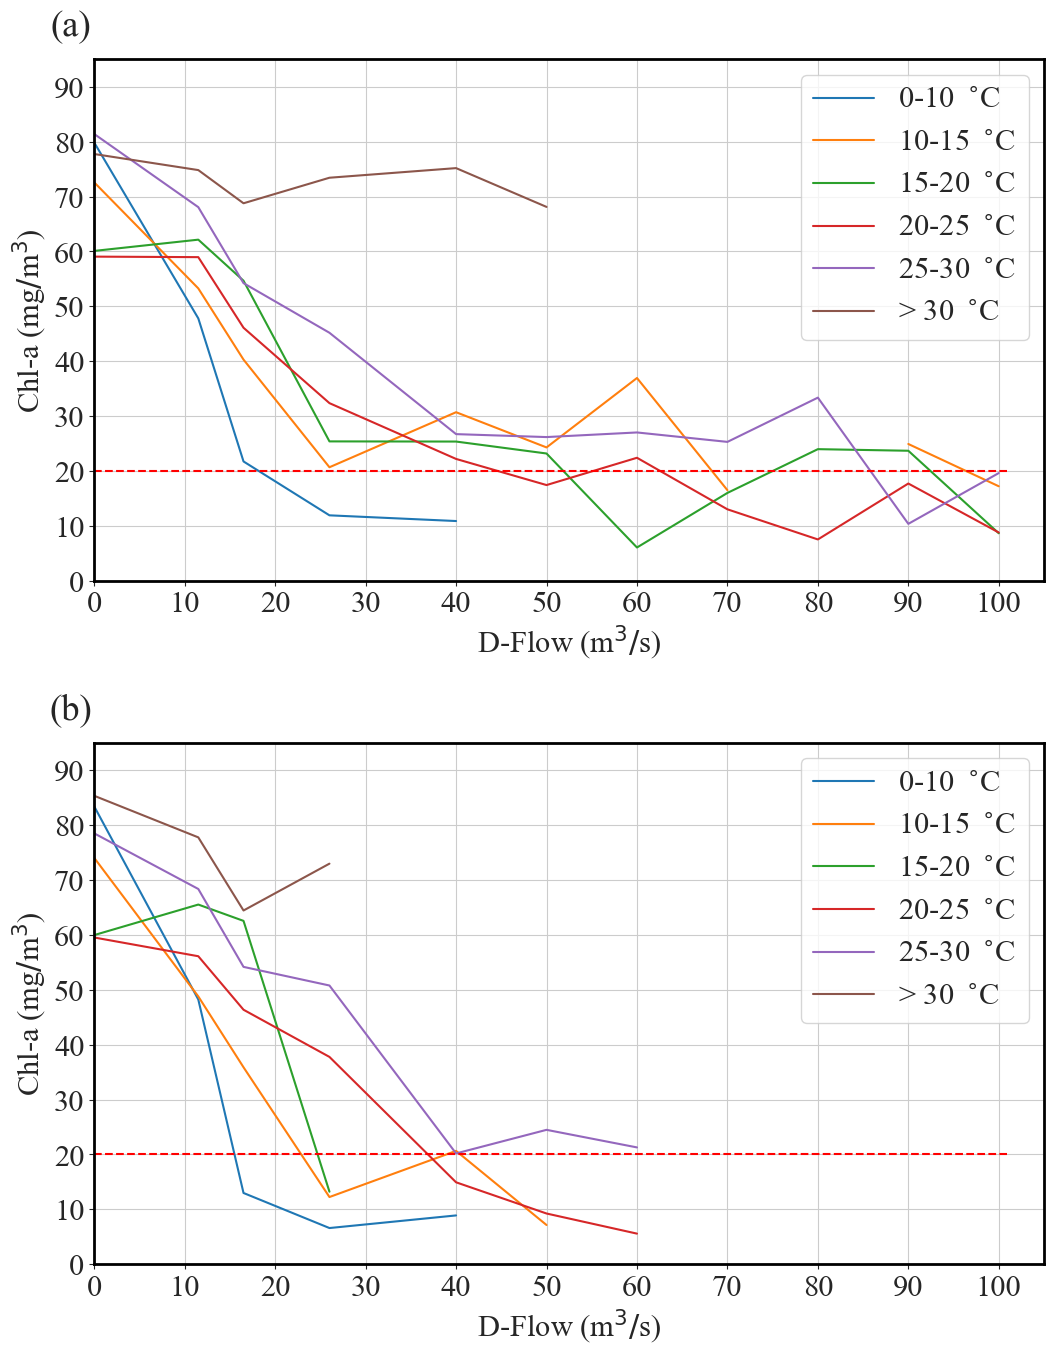

In [80]:
days = [1, 2]

fig, axes = plt.subplots(2, 1, figsize=(11, 14))
# fig.supxlabel('Discharge flow rate ($\mathdefault{m}^3/\mathdefault{s}$)', y=-0.05)
# fig.supylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)', x=0.08)
fig.subplots_adjust(hspace=0.3)

abcd = ['(a)', '(b)']

for i, ax in enumerate(axes.flatten()):
    df = discharge_temp_corr(discharge_bins, temp_bins, days=days[i], target='Chl-a')

    ax.plot(df)
    ax.legend(df.columns)

    # 20 mg/m3 기준선 추가
    xs = np.arange(0, 101, 0.1)
    ys = np.array([20]*len(xs))
    ax.plot(xs, ys, 'r--')


    ax.set_yticks(yticks)
    ax.set_xlabel('D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)', **csfont)
    ax.set_ylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
    ax.set_xticks(range(0, 101, 10))
    ax.set_yticks(range(0, 101, 10))

    ax.set_xlim(0, 105)
    ax.set_ylim(0, 95)

    ax.set_title(f'{abcd[i]}', y=1.03, x=-0.025)

    ax.legend([f'{temp_bins[i]}-{temp_bins[i+1]} $^\circ\!$C' for i in range(len(temp_bins)-1)] + [f'> {temp_bins[-1]} $^\circ\!$C'])
    
save_fig('figure9a')
plt.show()

### 계절별 그래프와 수온별 그래프 비교

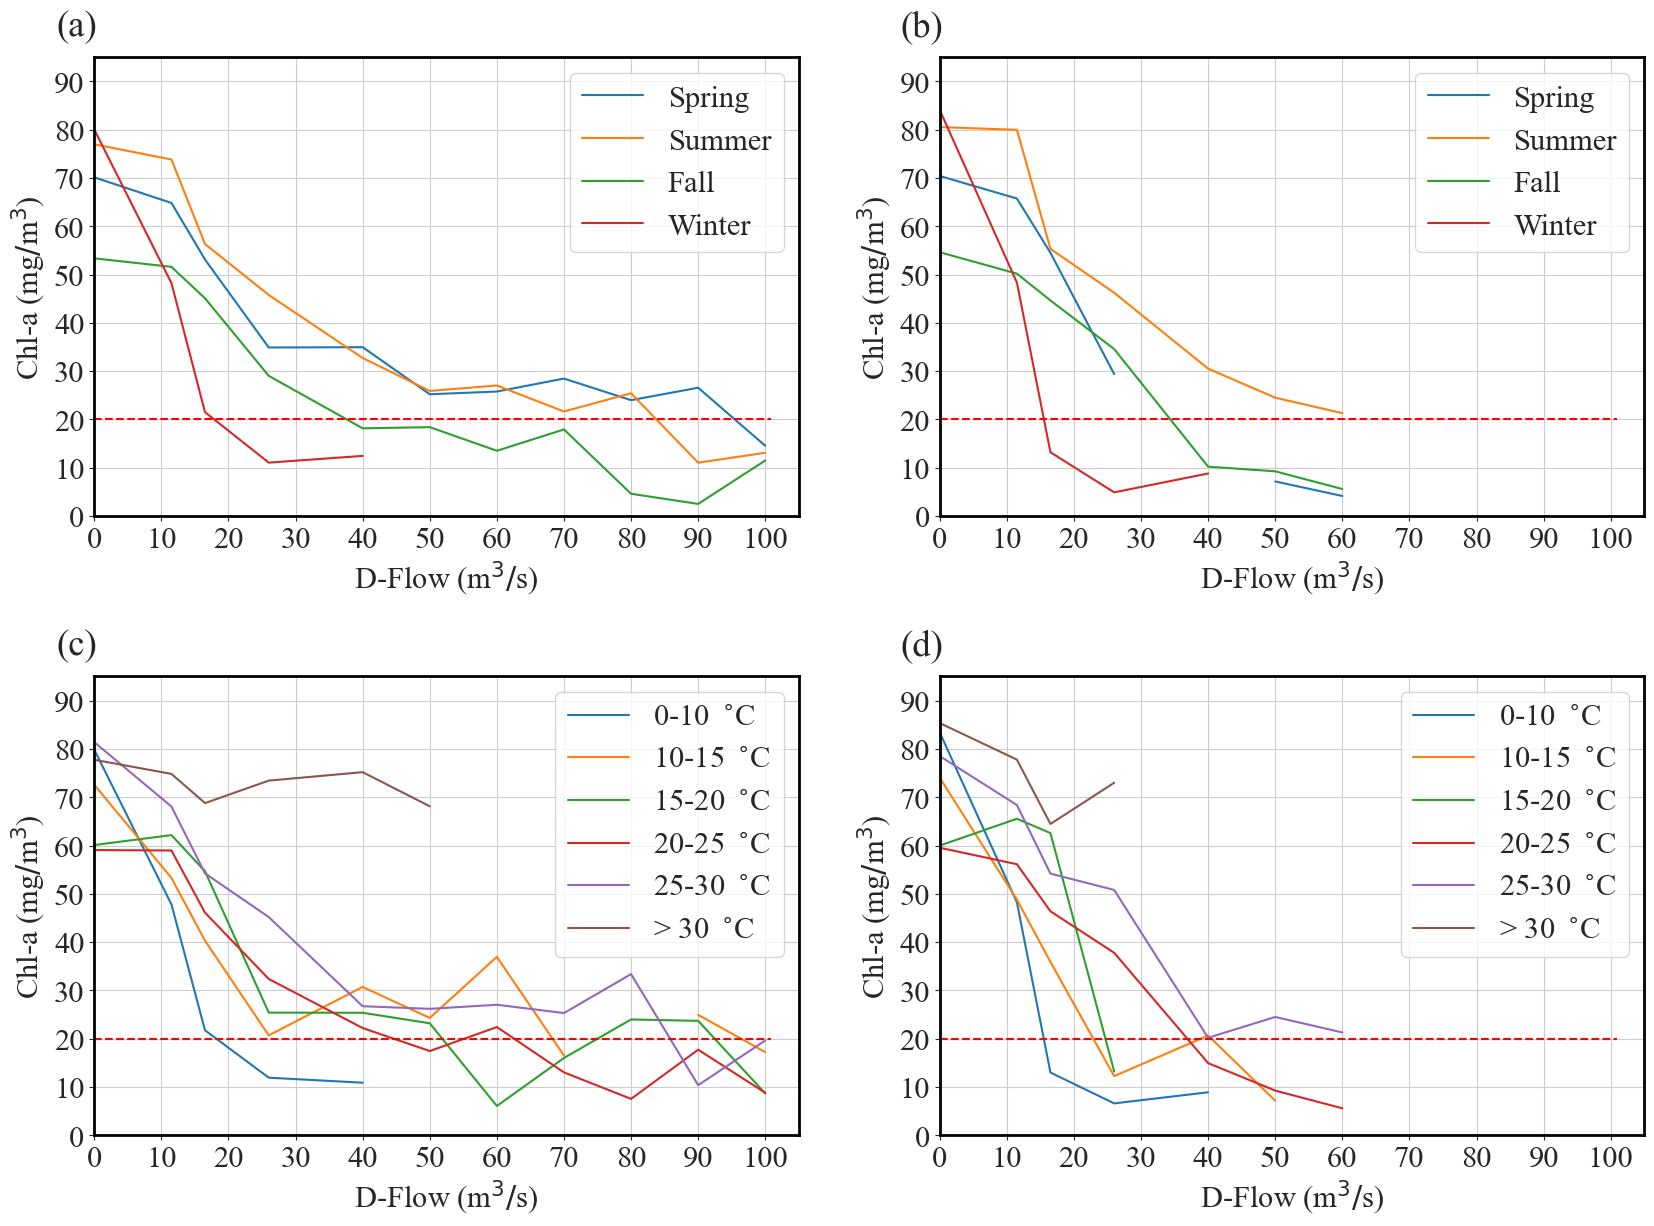

In [81]:
days = [1, 2] * 2 

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
# fig.supxlabel('Discharge flow rate ($\mathdefault{m}^3/\mathdefault{s}$)', y=-0.05)
# fig.supylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)', x=0.08)
fig.subplots_adjust(hspace=0.35)

abcd = ['(a)', '(b)', '(c)', '(d)']

yticks = np.arange(0, 101, 20)

for i, ax in enumerate(axes.flatten()):
    if i < 2:
        df = seasonal_min_level_fordays(days=days[i])
    else:
        df = discharge_temp_corr(discharge_bins, temp_bins, days=days[i], target='Chl-a')

    ax.plot(df)
    ax.legend(df.columns)

    # 20 mg/m3 기준선 추가
    xs = np.arange(0, 101, 0.1)
    ys = np.array([20]*len(xs))
    ax.plot(xs, ys, 'r--')

    ax.set_yticks(yticks)
    ax.set_xlabel('D-Flow ($\mathdefault{m}^3/\mathdefault{s}$)')
    ax.set_ylabel('Chl-a ($\mathdefault{mg}/\mathdefault{m}^3$)')
    ax.set_xticks(range(0, 101, 10))
    ax.set_yticks(range(0, 101, 10))

    ax.set_xlim(0, 105)
    ax.set_ylim(0, 95)

    ax.set_title(f'{abcd[i]}', y=1.03, x=-0.025)
    # ax.set_title(f'{abcd[i]} Chl-a level for {days[i]} day(s)', y=1.03)

    if i < 2:
        ax.legend(['Spring', 'Summer', 'Fall', 'Winter'])
    else:
        ax.legend([f'{temp_bins[i]}-{temp_bins[i+1]} $^\circ\!$C' for i in range(len(temp_bins)-1)] + [f'> {temp_bins[-1]} $^\circ\!$C'])

plt.show()

이틀동안 수온 평균이 30도 이상인 경우 해당하는 데이터가 별로 없어서 초당 방류량 평균이 얼마이어야 수질이 보통이 될지는 확실하지 않지만
70 이상 되어야 할 것으로 추정된다.
이에 대한 근거는 아래 표에서 확인할 수 있다.

아래 표는 여름에 이틀동안 초당 방류량 평균이 일정 구간의 값을 유지할 때의 온도와 클로로필-a의 제3사분위수에 해당하는 값들을 포함한다.
평균 수온이 30도 이상인 경우 클로로필-a의 수치가 20 이하로 떨어지는 데이터는 없지만
평균 수온이 26도 정도이고 초당 방류량 평균이 60 이상일 때 클로로필-a의 제3사분위수가 22 정도이다.
반면에 수온이 26도 정도이고 방류량 평균이 80 이상일 때 클로로필-a의 제3사분위수가 6 정도로 떨어진다.
따라서 온도가 30 이상인 경우 최소 70 정도는 돼야 할 것으로 추정할 수 있다.

- 중위수

In [82]:
min_level_fordays(summer_scb_df_daily, days=2, bins=discharge_bins, targets=['Temp', 'Chl-a'], quartile='mean')

,Temp,Chl-a
0.0,29.738111,80.521887
11.5,28.964279,79.969933
16.5,27.822616,55.317070
26.0,27.231176,46.217398
40.0,26.100233,30.503026
50.0,26.386111,24.488194
60.0,25.758333,21.285417
70.0,NaN,NaN
80.0,26.054167,6.225000
90.0,NaN,NaN


- 3사분위수

In [83]:
min_level_fordays(summer_scb_df_daily, days=2, bins=discharge_bins, targets=['Temp', 'Chl-a'], quartile='75%')

,Temp,Chl-a
0.0,31.910417,91.750000
11.5,32.164205,89.134375
16.5,29.338706,75.098641
26.0,29.341667,62.880952
40.0,27.076042,35.468977
50.0,26.762500,32.605208
60.0,25.818750,22.242708
70.0,NaN,NaN
80.0,26.054167,6.225000
90.0,NaN,NaN
